## Libraries
<hr>
The libraries used are pandas, numpy, seaborn, Counter, matplotlib, axes3d, linearregression.

In [2]:
#data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sklearn
from collections import Counter
from sklearn import datasets, linear_model, cross_validation
from sklearn.metrics import mean_squared_error, r2_score
#import geocoder

#visualization
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython.display import IFrame

# machine learning library
from sklearn import datasets, linear_model, cross_validation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#import xgboost as xgb
from sklearn.neural_network import MLPRegressor

# other
import time

In [4]:
#load dataset
data1 = pd.read_csv('sg-resale-flat-prices-1990-1999.csv', sep =',')
print('Number of training data =', data1.shape)

data2 = pd.read_csv('sg-resale-flat-prices-2000-2005.csv', sep =',')
print('Number of training data =', data2.shape)

data3 = pd.read_csv('sg-resale-flat-prices-2006-2012.csv', sep =',')
print('Number of training data =', data3.shape)

data4 = pd.read_csv('sg-resale-flat-prices-2012-2014.csv', sep =',')
print('Number of training data =', data4.shape)

data5 = pd.read_csv('sg-resale-flat-prices-2014-2018.csv', sep =',')
print('Number of training data =', data5.shape)

#drop extra column
data5 = data5.drop('remaining_lease',1)
print('Number of training data =', data5.shape)

#concatenate dataset
sets = [data1, data2, data3, data4, data5]
data = pd.concat(sets)
print('Number of training data =', data.shape)

Number of training data = (288144, 10)
Number of training data = (197175, 10)
Number of training data = (172476, 10)
Number of training data = (52203, 10)
Number of training data = (58631, 11)
Number of training data = (58631, 10)
Number of training data = (768629, 10)


## 2 Exploration of the Dataset
<hr>

### 2.1 Data description and information

In [5]:
#load dataset
n = data.shape[0]
print('Number of training data:',n)
print('Our data has',data.shape[1],'features.')

Number of training data: 768629
Our data has 10 features.


We use data.describe() to have a look at some key metrics of the data set.

In [65]:
print(data.describe())

       floor_area_sqm  lease_commence_date  resale_price
count   768629.000000        768629.000000  7.686290e+05
mean        95.455564          1986.563476  2.823196e+05
std         26.210450             8.851260  1.424499e+05
min         28.000000          1966.000000  5.000000e+03
25%         72.000000          1980.000000  1.750000e+05
50%         93.000000          1985.000000  2.650000e+05
75%        114.000000          1993.000000  3.700000e+05
max        307.000000          2015.000000  1.180000e+06


We can conclude:
- All appartments vary between the size of 26.2 and 307 sqm. The median is 95.3 sqm.
- The oldest lease start date is 1996 and the oldest one is 2012. Thus no appartment in this list has a lease that expires before 2066. The mean lease start date is 1987. 
- Resale prices vary between 5000 SGD and 1.18 million SGD. It has to be verified if a price of 5000SGD is possible or is due to faulty data. The median price lies at 260k SGD.
- Overall, at a first glance the dataset seems to be clean and free of faulty datapoints. <br>

Let's have a look at the data types:

In [66]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768629 entries, 0 to 58630
Data columns (total 10 columns):
month                  768629 non-null object
town                   768629 non-null object
flat_type              768629 non-null object
block                  768629 non-null object
street_name            768629 non-null object
storey_range           768629 non-null object
floor_area_sqm         768629 non-null float64
flat_model             768629 non-null object
lease_commence_date    768629 non-null int64
resale_price           768629 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 64.5+ MB
None


We can see that the data list is complete, as all features have 768,629 values. <br>

After loading the data, the data are explored. Features are checked to see whether cleaning and preprocessing of the data is needed.

## 2.2 Univariate plots

#### 2.2.1 Time of Sale

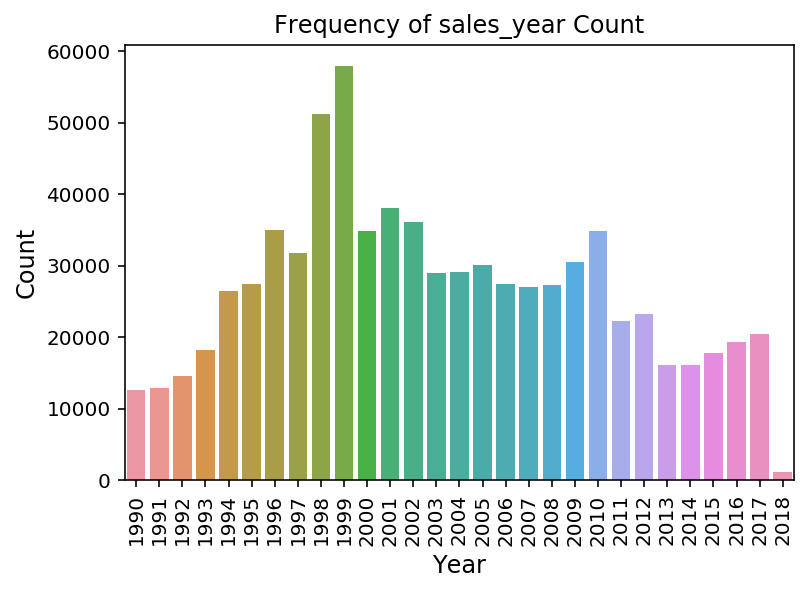

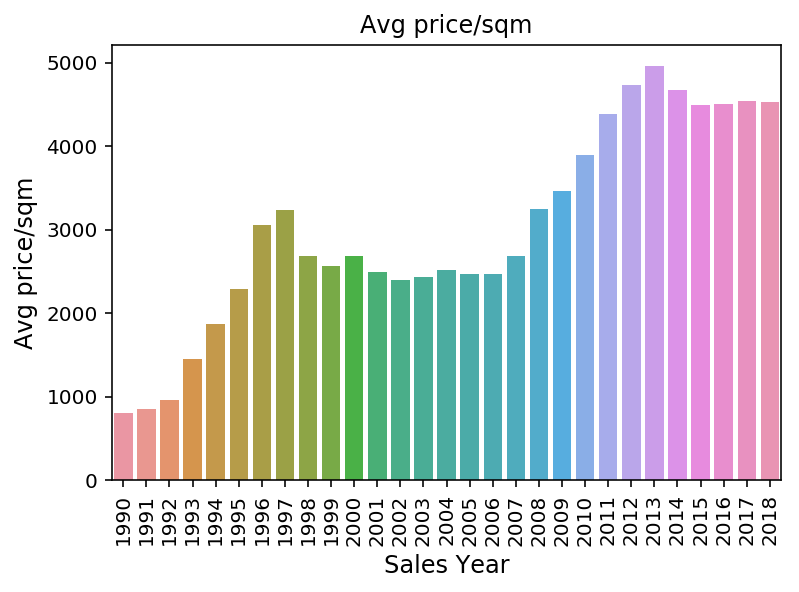

In [67]:
#yearly sales trend

sales_year = np.unique(pd.DatetimeIndex(data['month']).year.values)
year_count=pd.DatetimeIndex(data['month']).year.value_counts()

sns.barplot(year_count.index, year_count.values, order=sales_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()
#sales_year_count = (pd.DatetimeIndex(data['month']).year).value_counts()
#print("Sales Year Count \n" +str(sales_year_count))

#sales year vs avg price/sqm
n = len(sales_year)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).year == sales_year[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).year == sales_year[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(sales_year,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Sales Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- In our dataset, sales rose between 1990 and 1999 and then continuously dropped to around 20,000 in 2017.
- 2018 is included in the dataset, but only seems to contain a marginal amount of sales.
- As expected, in general, prices per sqm increase over time.
- However there was a dip after 1997 and after 2013.

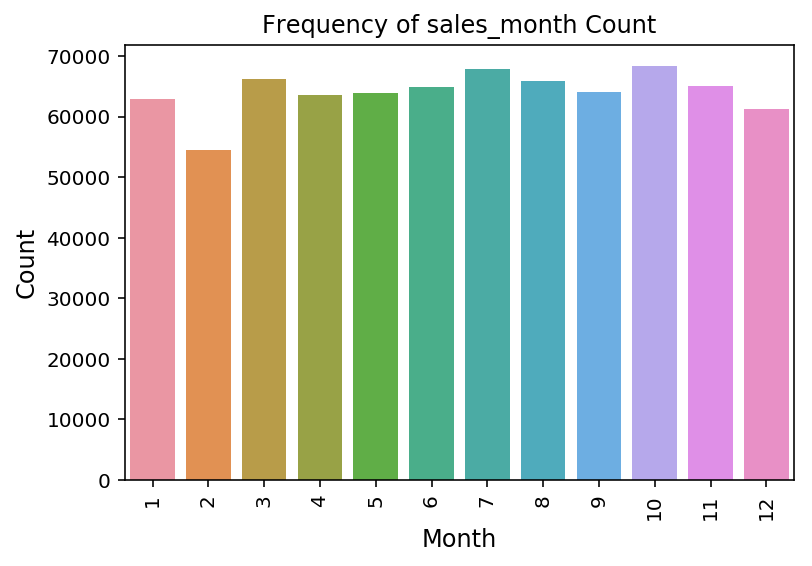

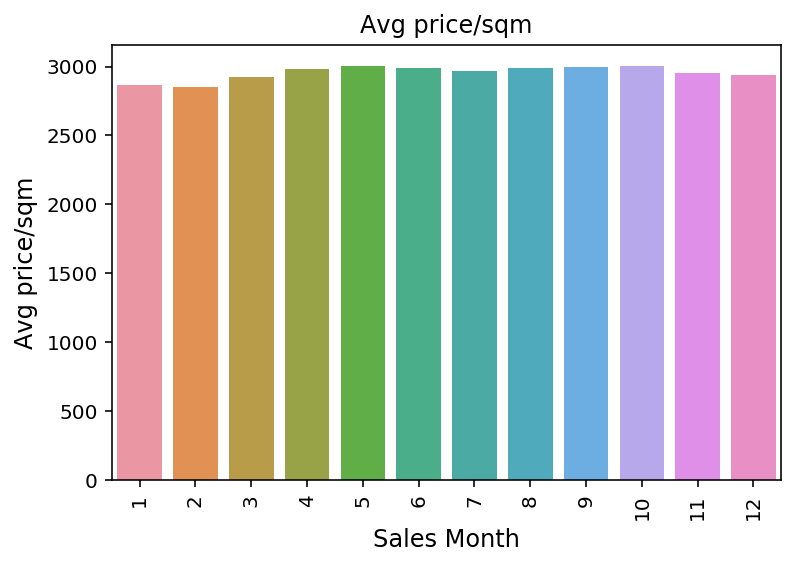

In [68]:
#monthly sales trend

sales_month = np.unique(pd.DatetimeIndex(data['month']).month.values)
month_count=pd.DatetimeIndex(data['month']).month.value_counts()

sns.barplot(month_count.index, month_count.values, order=sales_month)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_month Count", fontsize=12)
plt.show()
#sales_month_count = (pd.DatetimeIndex(data['month']).month).value_counts()
#print("Sales Month Count \n" +str(sales_month_count))

#sales month vs avg price/sqm
n = len(sales_month)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).month == sales_month[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).month == sales_month[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(sales_month,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Sales Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- It seems like the last and first month of a year have slightly lower prices than the middle months. <br>

#### 2.2.2 Feature: Lease Commencement Year

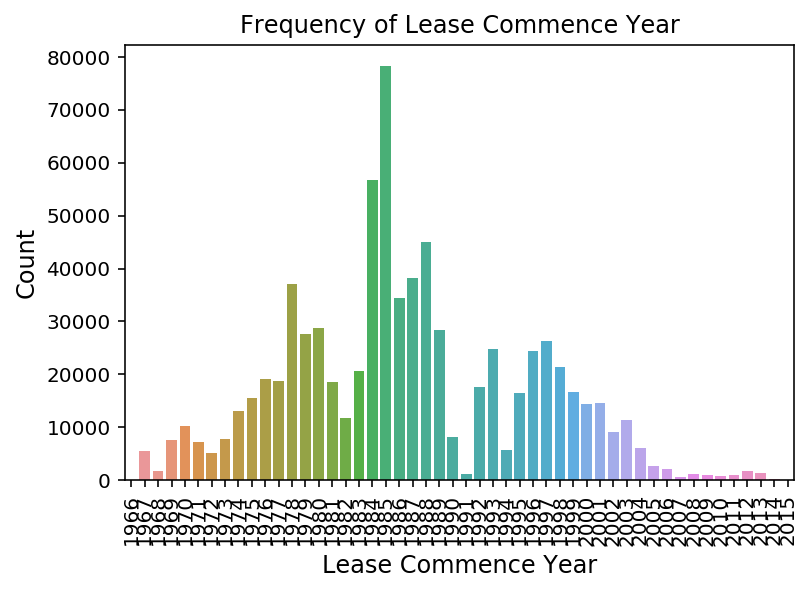

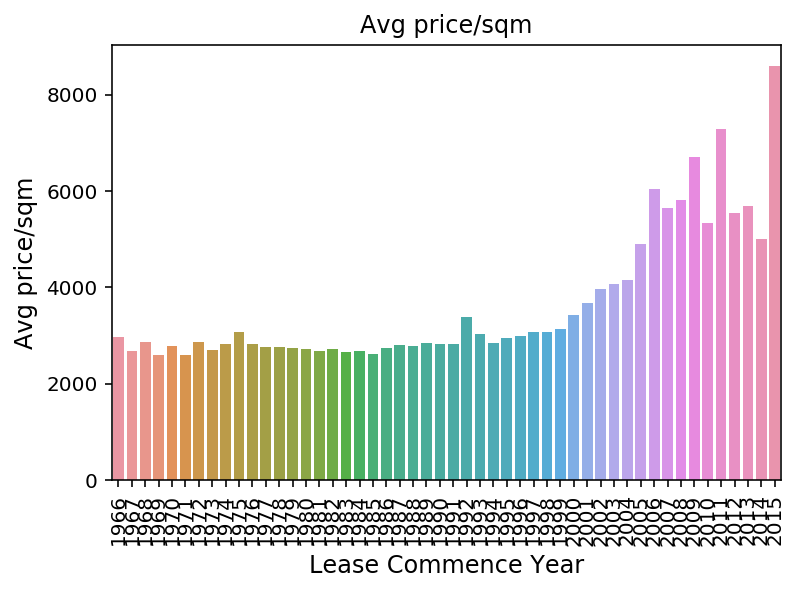

In [69]:
#lease commencement year

lease_commence = np.unique(data['lease_commence_date'])

sns.countplot(x="lease_commence_date", data=data , order = lease_commence)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Lease Commence Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Lease Commence Year", fontsize=12)
plt.show()
#lease_commence_count = data['lease_commence_date'].value_counts()
#print("Lease Commence Count \n" +str(lease_commence_count))

#town vs avg price/sqm
n = len(lease_commence)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['lease_commence_date'] == lease_commence[i]].sum()
        sqmm = data['floor_area_sqm'][data['lease_commence_date'] == lease_commence[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(lease_commence,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Lease Commence Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- The years 1984-1990 have the most commencement dates. Before, there is an ongoing increase and afterwards an ongoing decrease.
- Prices/sqm remain relatively flat for commencement dates from 1966 to 2000 and increase from 2000 to 2012. After 2012 the prices decrease heavily and in 2015, it almost doubled again. <br>


#### 2.2.3 Feature: Town

Total Town Count: 27


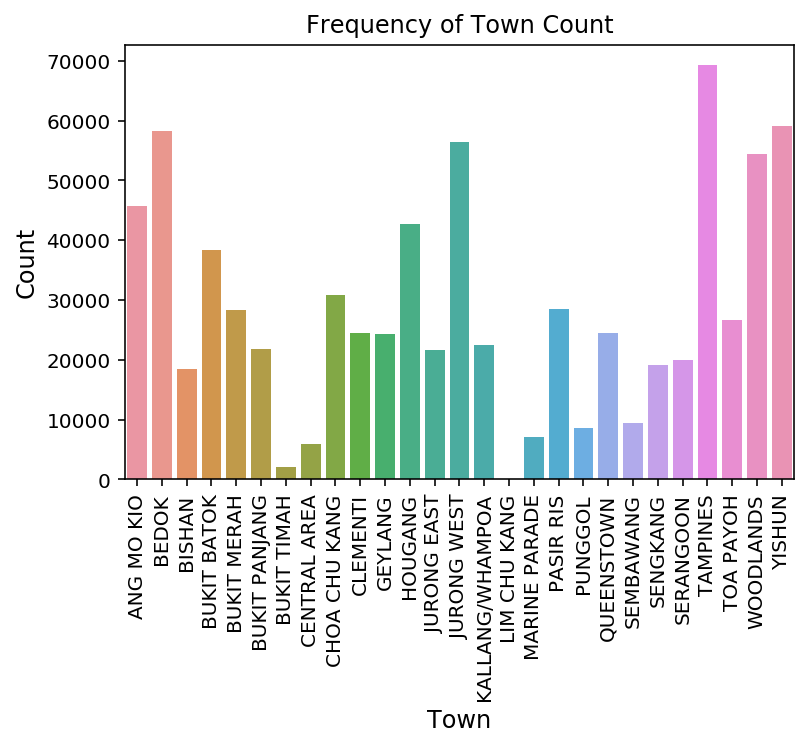

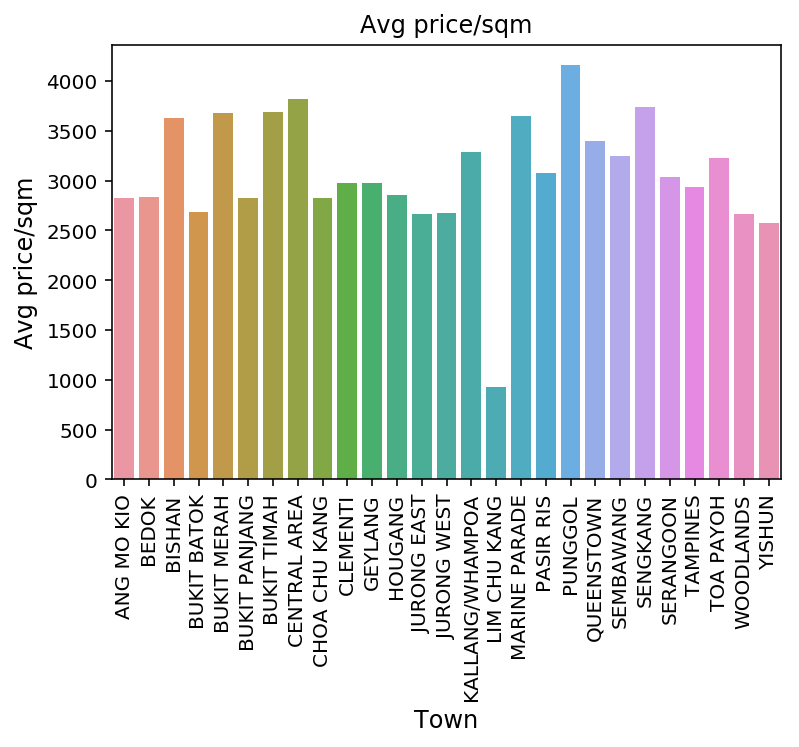

In [70]:
#town count
count_towns = data['town'].nunique()
print("Total Town Count:", count_towns)

town = np.unique(data['town'])

sns.countplot(x="town", data=data , order = town)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Town Count", fontsize=12)
plt.show()
#towns_count = data['town'].value_counts()
#print("Town Count \n" +str(towns_count))

#town vs avg price/sqm
n = len(town)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['town'] == town[i]].sum()
        sqmm = data['floor_area_sqm'][data['town'] == town[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(town,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- Besides Bukit Timah and Lim Chu Kang, all towns have more than 5000 sales occurrences.
- TAMPINES is the most present town, with 69236 sales.
- Lim Chu Kang is a clear outlier in terms of price/sqm. This is probably correlated to the low number of only 64 sales registered in that area.
- The most expensive town is Punggol. 

### Singaporean Townships and Areas
The Housing and Development Board makes a distinction between a total of 23 townships, located in 5 different areas [12]. The areas define their location within the city-state, whereas the township concatenates a community with its own council. The map below highlights the areas and townships. The areas are respectively: north (red), nort-east (yellow), east (blue), central (brown) and west (green). The pins indicate the townships included.

In [71]:
IFrame('https://www.google.com/maps/d/u/0/embed?mid=1Gv4-kVYanSXMj8Q2ldJKJkzTilOlEZxL', width=800, height=300)

#### 2.2.4 Feature: Flat Type

Total Flat Type Count: 8


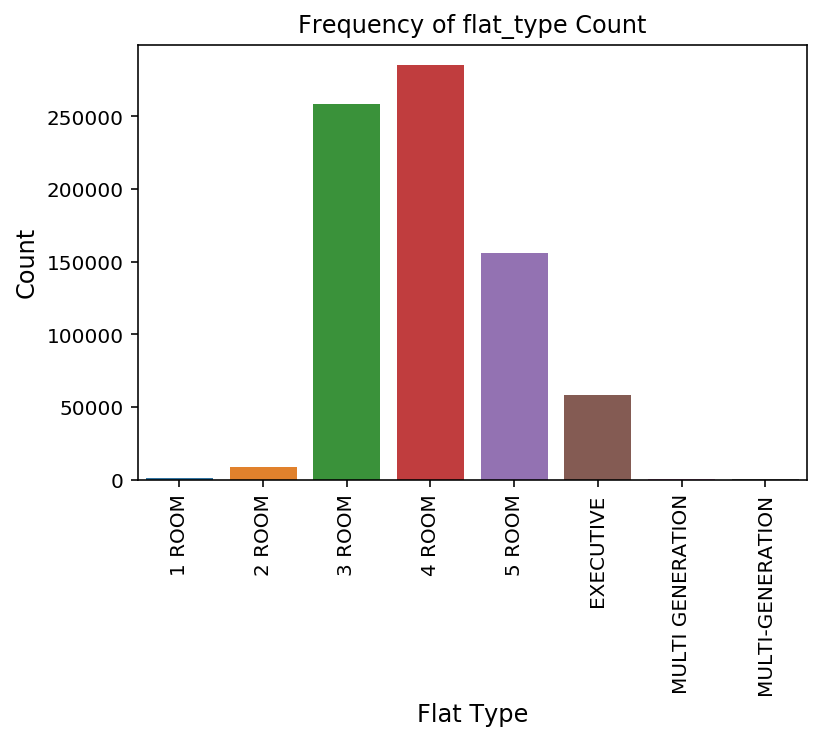

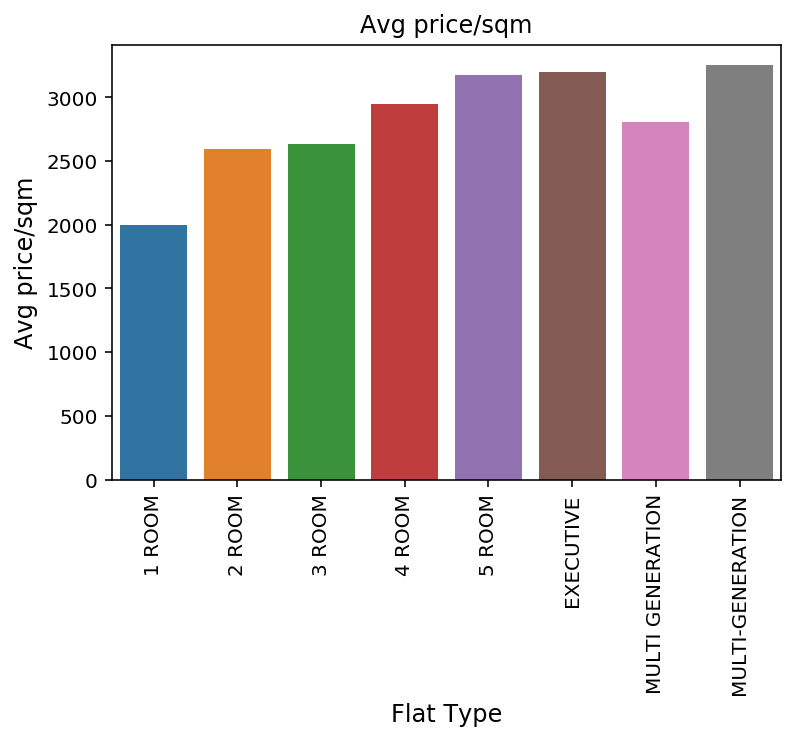

In [72]:
#flat_type count
count_flat_type = data['flat_type'].nunique()
print("Total Flat Type Count:", count_flat_type)
#flat_type_count = data['flat_type'].value_counts()
#print("Flat Type Count \n" +str(flat_type_count))

flat_type = np.unique(data['flat_type'])

sns.countplot(x="flat_type", data=data , order = flat_type)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Flat Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_type Count", fontsize=12)
plt.show()

#flat type vs avg price/sqm
n = len(flat_type)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_type'] == flat_type[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_type'] == flat_type[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(flat_type,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- 1 Room, 2 Room, and Multi-Generations are clearly fewer than the remaining flat types.
- The most common flat type is 4 rooms.
- Prices per sqm, surprisingly, seem to up with flat size. <br>

#### 2.2.5 Feature: Flat Model

Total Flat Model Count: 34


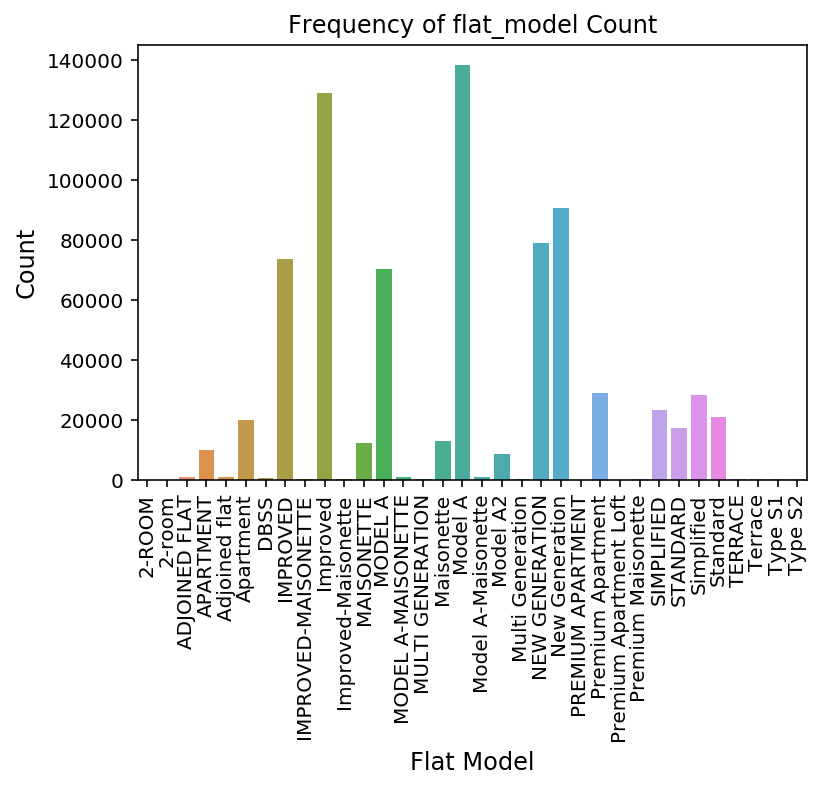

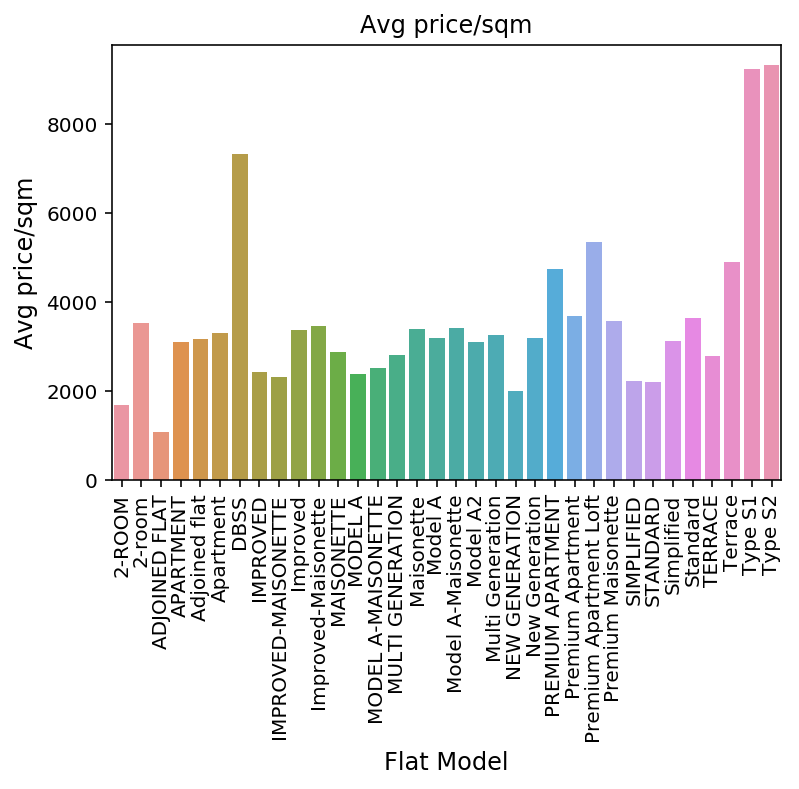

In [73]:
#flat_model count
count_flat_model = data['flat_model'].nunique()
print("Total Flat Model Count:", count_flat_model)
#flat_model_count = data['flat_model'].value_counts()
#print("Flat Model Count \n" +str(flat_model_count))

flat_model = np.unique(data['flat_model'])

sns.countplot(x="flat_model", data=data , order = flat_model)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_model Count", fontsize=12)
plt.show()

#flat model vs avg price/sqm
n = len(flat_model)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_model'] == flat_model[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_model'] == flat_model[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(flat_model,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Obersvations:
- Concerning flat_models, there are lot of flat_models that exist less than a 1000 times.
- The most common ones are 'Model A' and 'Improved'.
- Prices/sqm vary widely, which is probably due to some sample sizes being very small. <br>

#### 2.2.6 Feature: Storey Range

Total Storey Range Count: 25


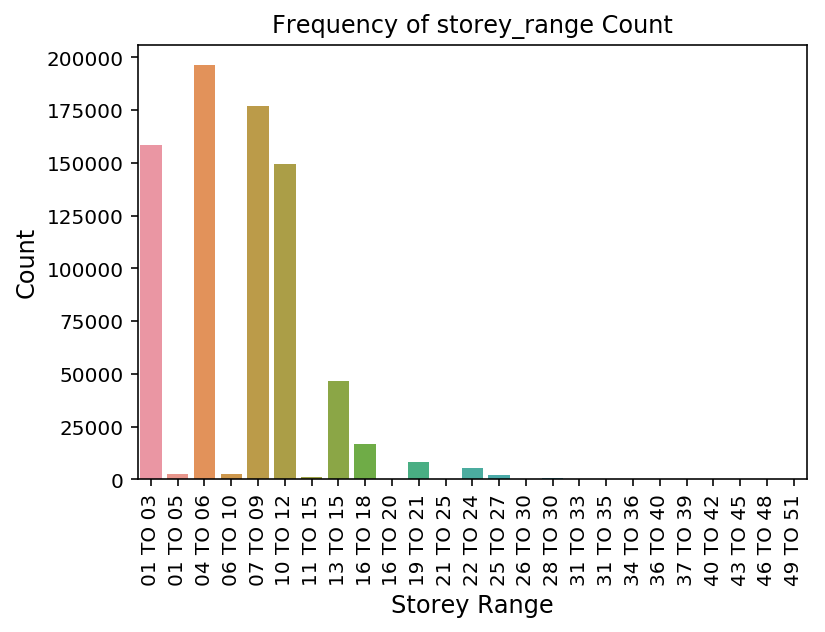

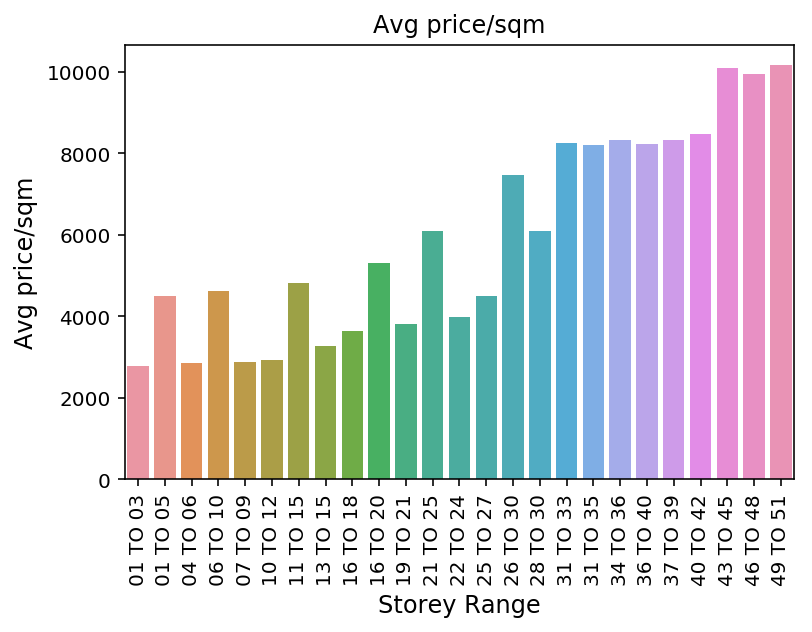

In [74]:
#storey range count
count_storey_range = data['storey_range'].nunique()
print("Total Storey Range Count:", count_storey_range)
#storey_range_count = data['storey_range'].value_counts()
#print("Storey Range Count \n" +str(storey_range_count))

storey_array = np.unique(data['storey_range'])

sns.countplot(x="storey_range", data=data , order = storey_array)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Storey Range', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of storey_range Count", fontsize=12)
plt.show()

#storey range vs avg price/sqm
n = len(storey_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['storey_range'] == storey_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['storey_range'] == storey_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(storey_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Storey Range', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- There is a clear upwards trend in prices for higher stories.
- There are few storey ranges that spike in price.
- Those ranges also tend to have really low frequency.
- These ranges also tend to be included in other ranges.
- It is possible that e.g. in recent years, which have higher prices, the storey format changed; which would explain higher avg. prices per sqm. <br>

#### 2.2.7 Feature: Squared Meters Distribution

Total SQM Range Count: 209


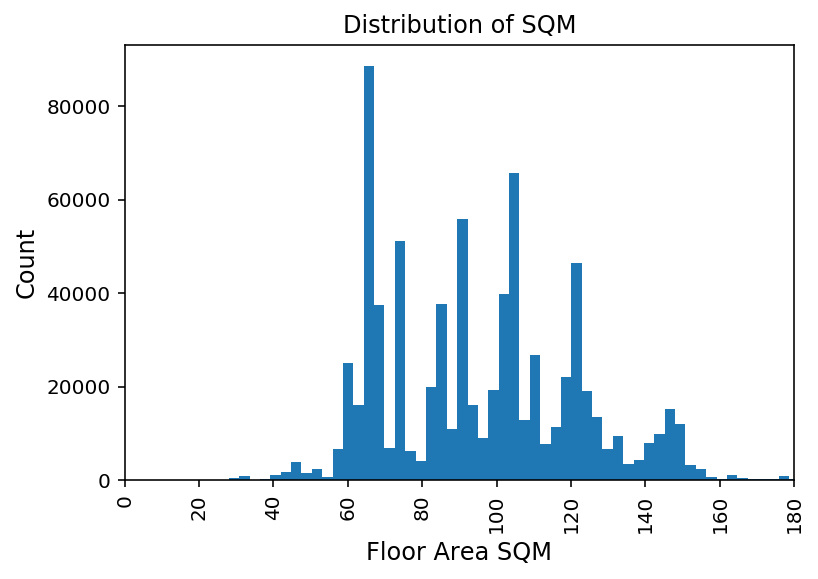

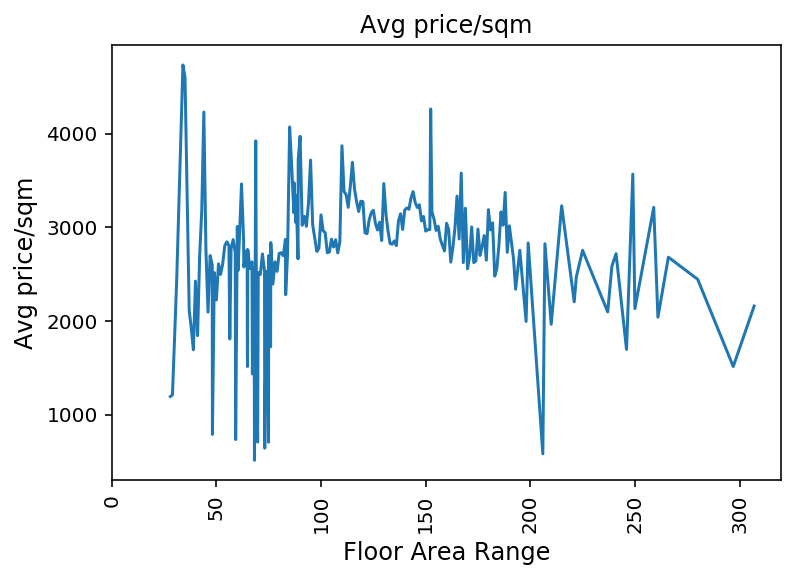

In [75]:
#SQM distribution
count_sqm = data['floor_area_sqm'].nunique()
print("Total SQM Range Count:", count_sqm)
#sqm_count = data['floor_area_sqm'].value_counts()
#print("SQM Range Count \n" +str(sqm_count))

sqm_area = np.unique(data['floor_area_sqm'])

plt.hist(data['floor_area_sqm'], bins = 100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Floor Area SQM', fontsize=12)
plt.xlim(0,180)
plt.xticks(rotation='vertical')
plt.title("Distribution of SQM", fontsize=12)
plt.show()

#storey range vs avg price/sqm
n = len(sqm_area)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['floor_area_sqm'] == sqm_area[i]].sum()
        sqmm = data['floor_area_sqm'][data['floor_area_sqm'] == sqm_area[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
plt.plot(sqm_area,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Floor Area Range', fontsize=12)
plt.xlim(0,320)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- We can see that the largest chunk of the HBDs are between 25 and 200 sqm.
- There are strong variations of counts between the different bins.
- Prices per sqm seem to be highest in the mid-range of SQM. <br>

#### 2.2.8 Feature: Resale Price

Total Resale Price Range Count: 8082


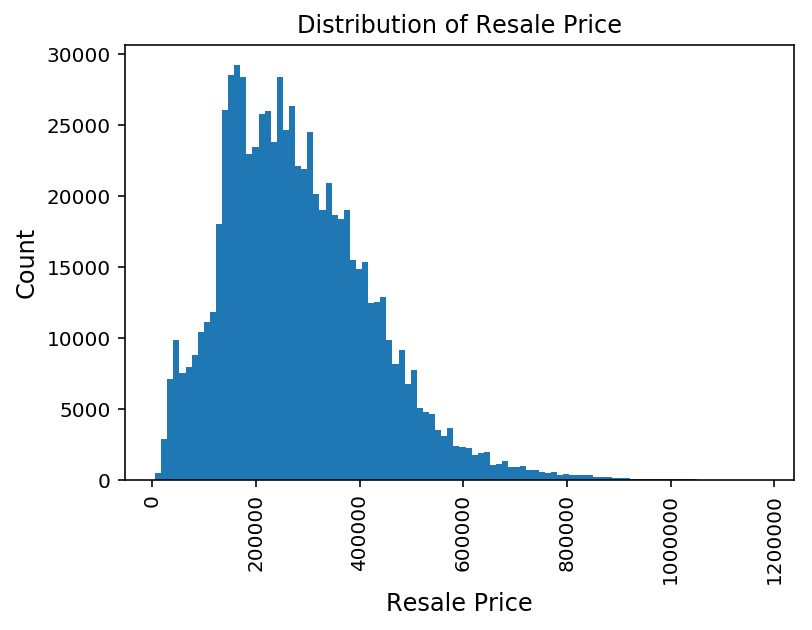

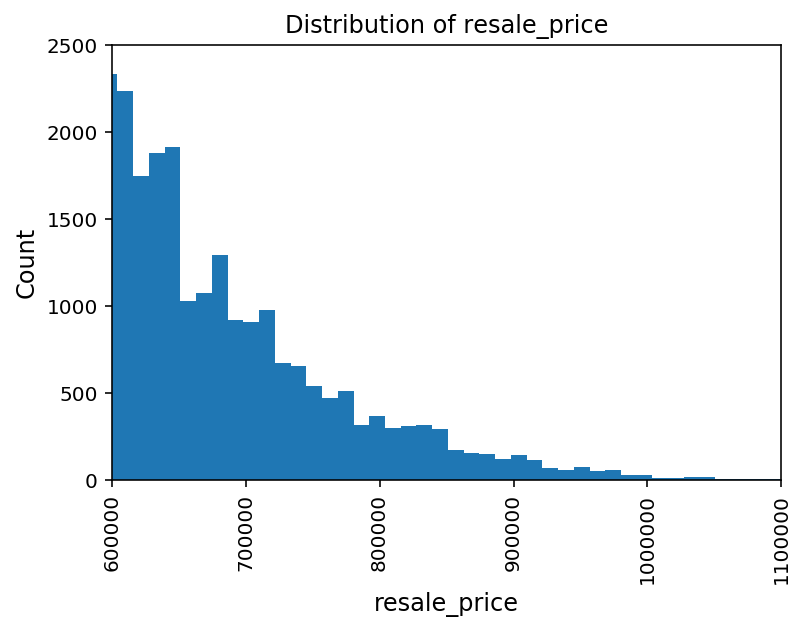

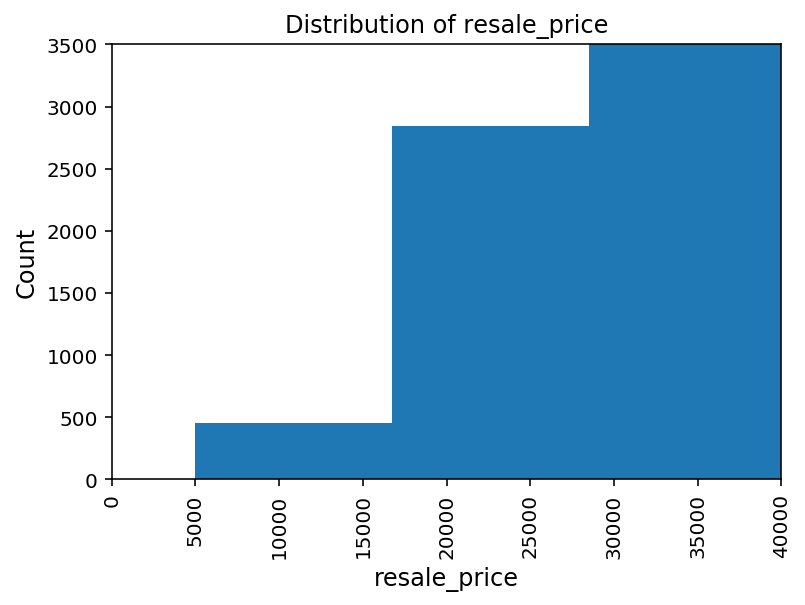

In [76]:
#resale price distribution
count_price = data['resale_price'].nunique()
print("Total Resale Price Range Count:", count_price)
#price_count = data['resale_price'].value_counts()
#print("Resale Price Range Count \n" +str(price_count))

plt.hist(data['resale_price'], bins = 100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Resale Price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of Resale Price", fontsize=12)
plt.show()

#resale prices above $1,000,000
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,2500)
plt.xlim(600000,1100000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

#resale prices under $10,000
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,3500)
plt.xlim(0,40000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

Observations:
- Practically no prices per flat go above 1,000,000 SGD.
- The majority of prices are between 150,000 and 400,000 SGD.
- There seems to be a number of flats (400+) that were sold for less than 10,000 SGD. <br>

### 2.3 Correlations

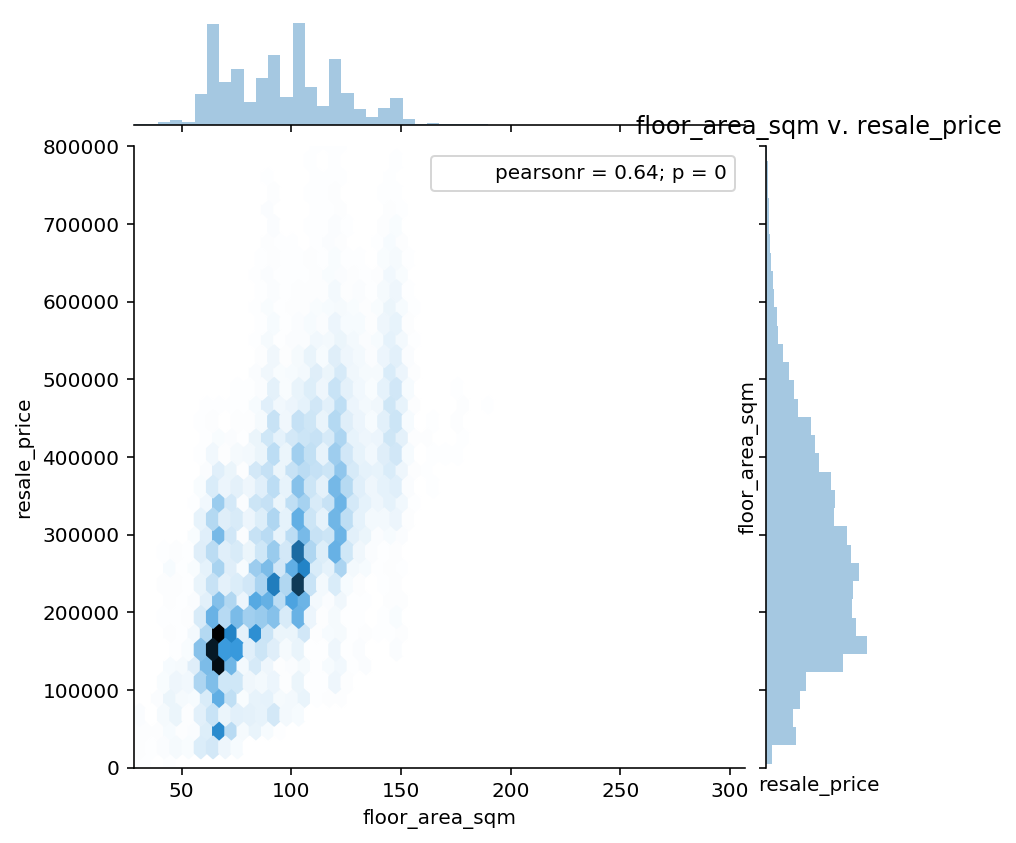

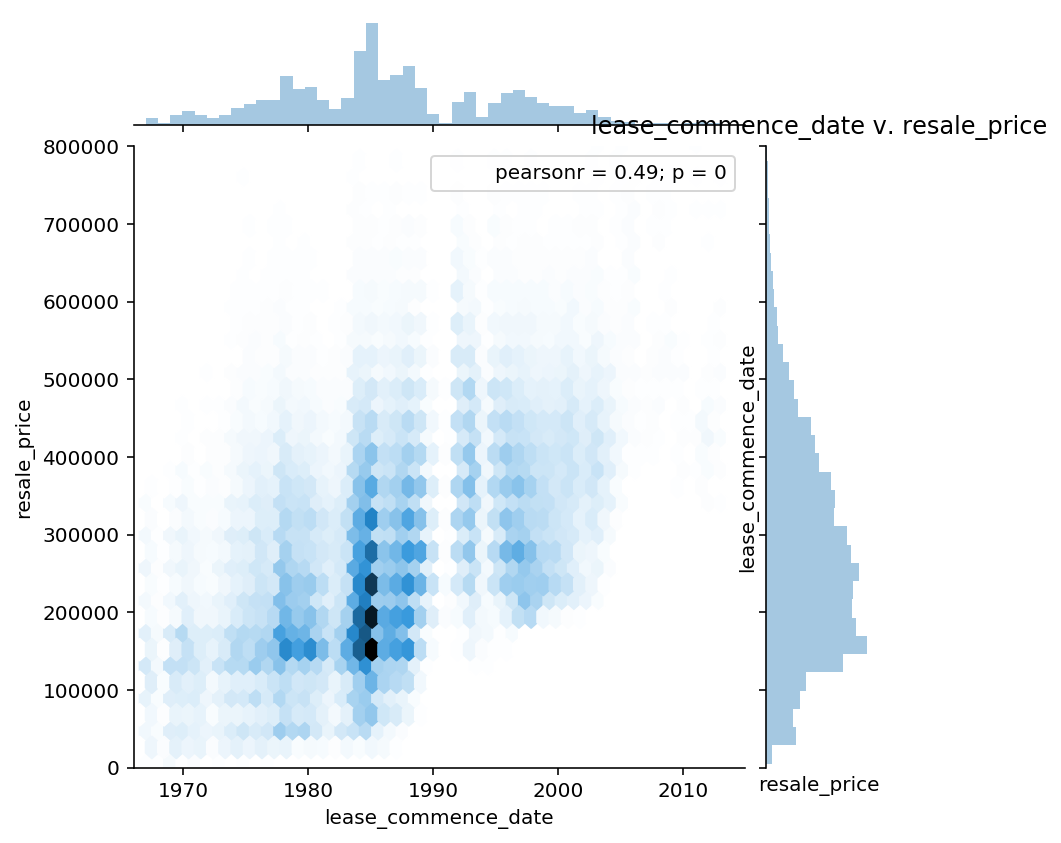

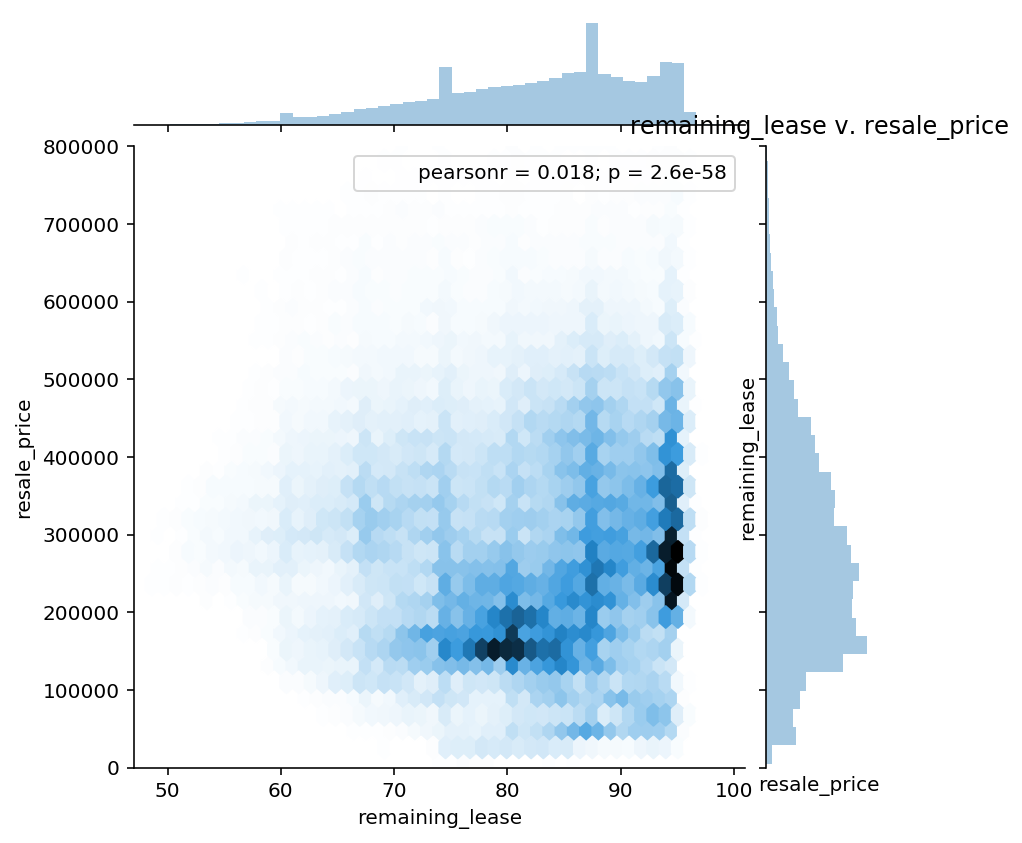

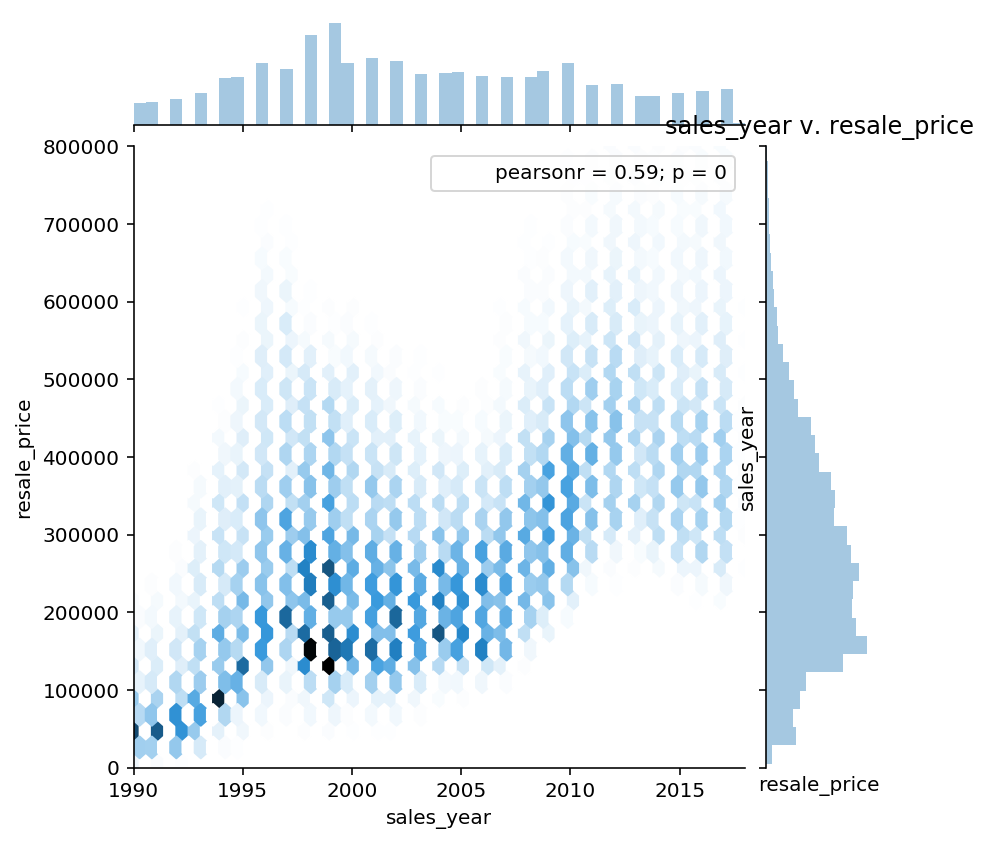

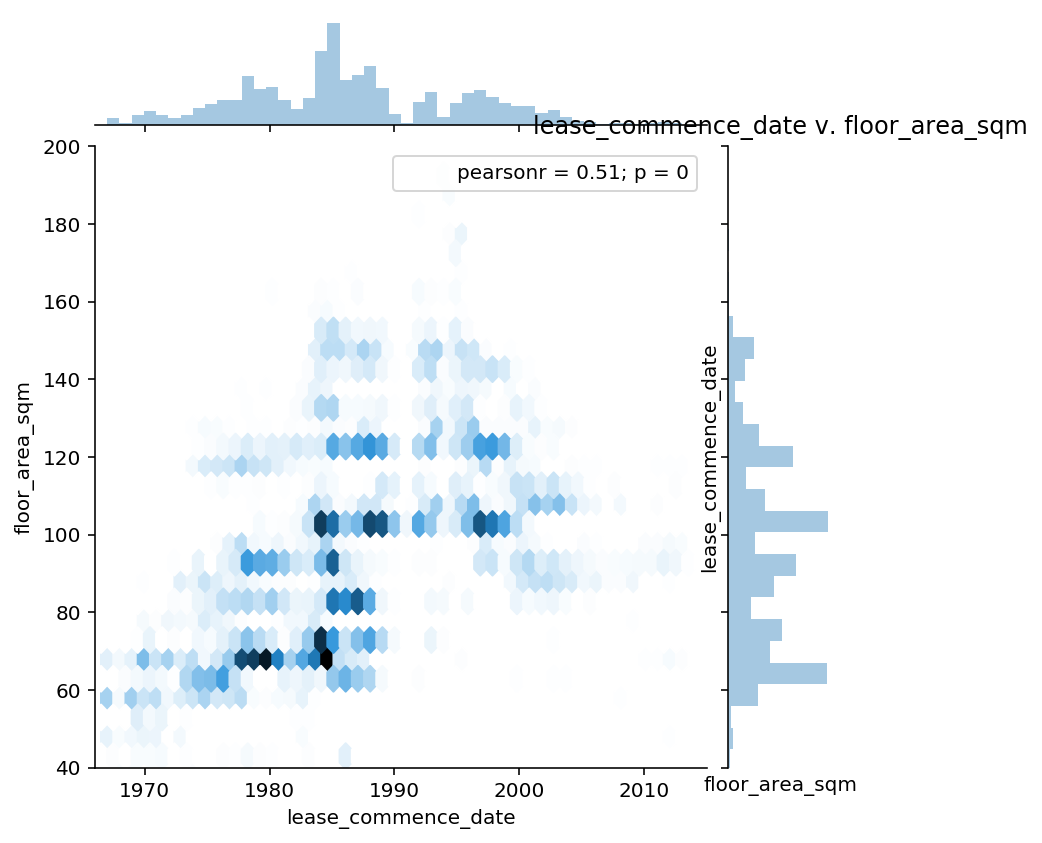

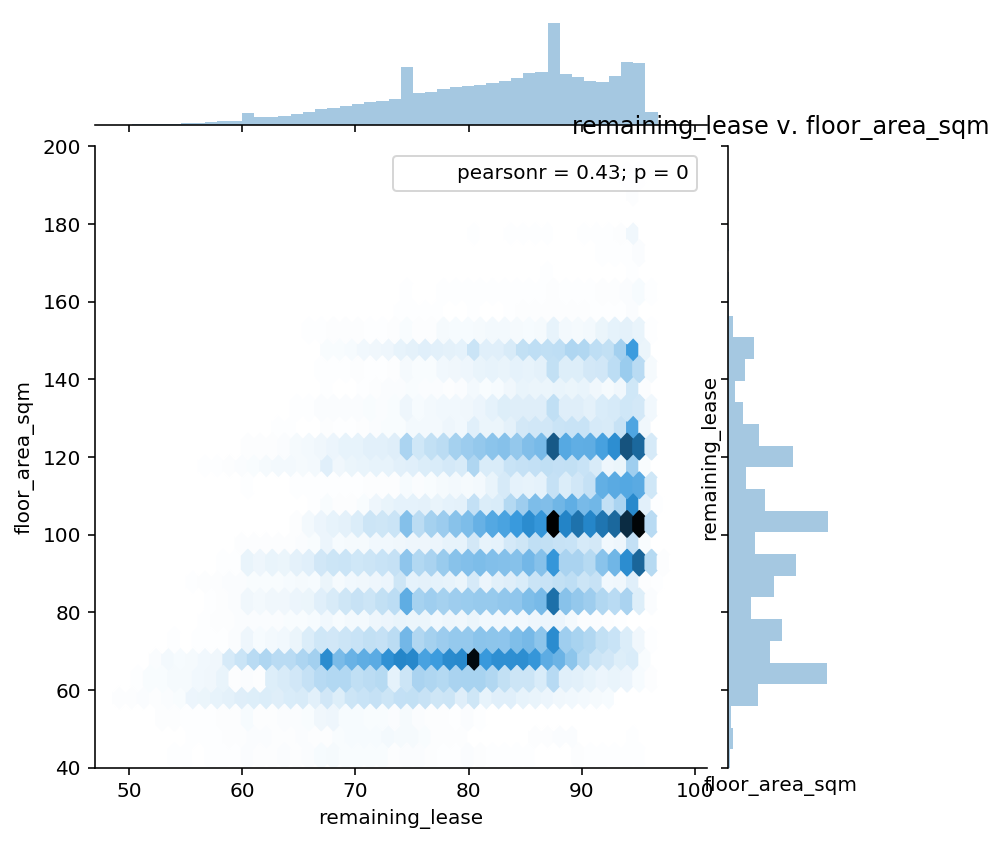

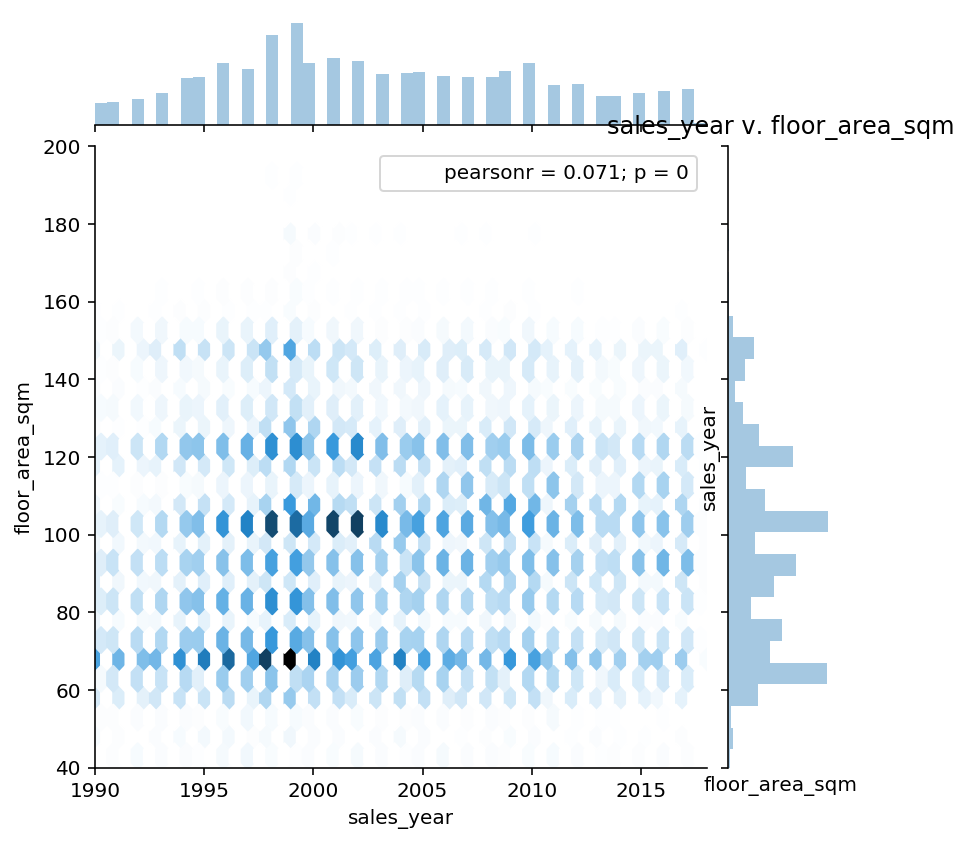

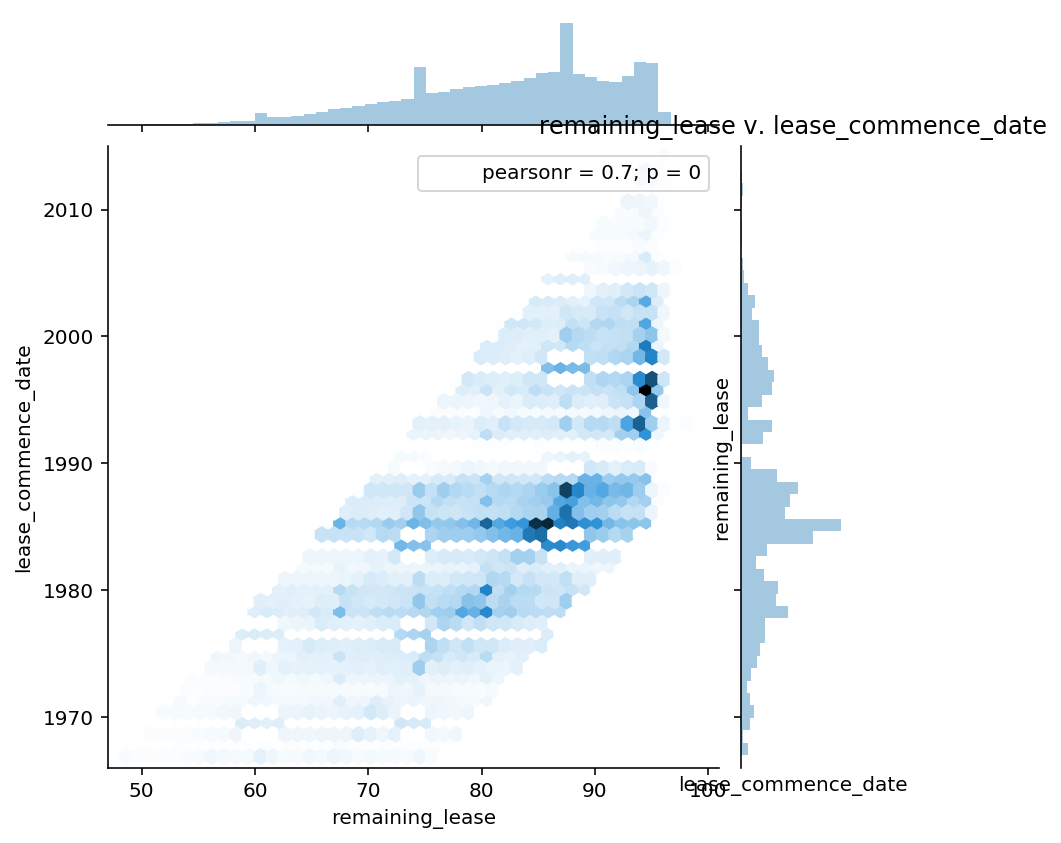

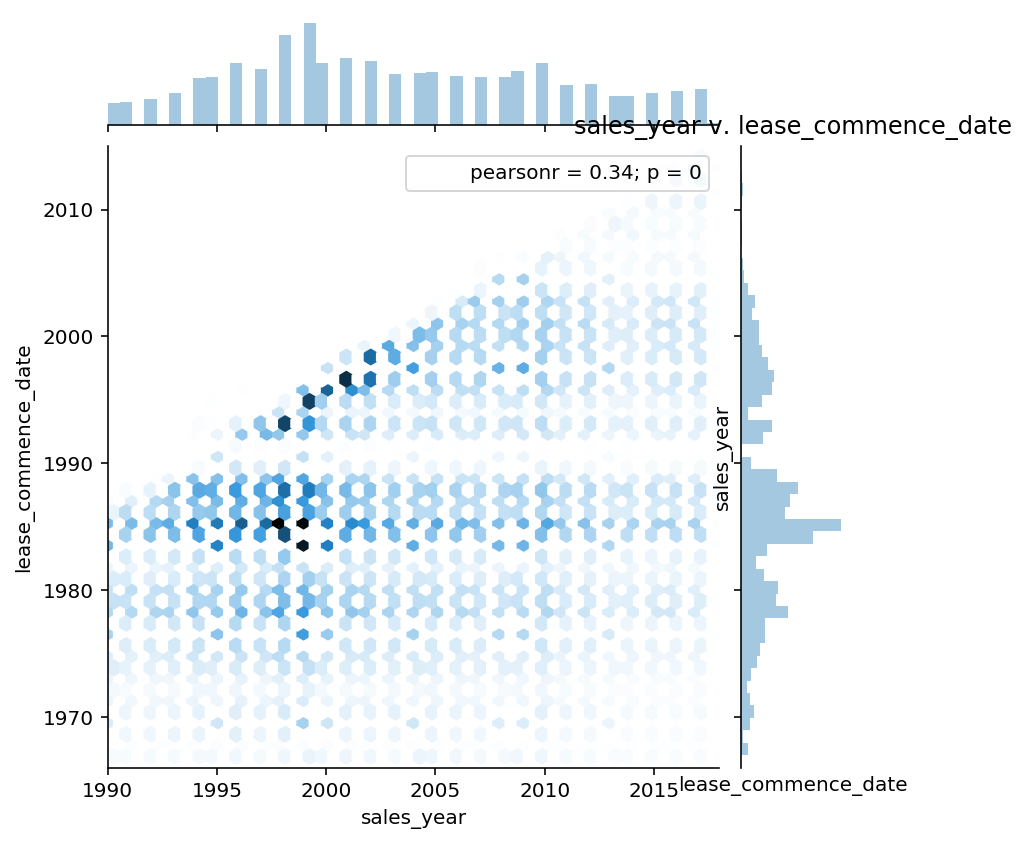

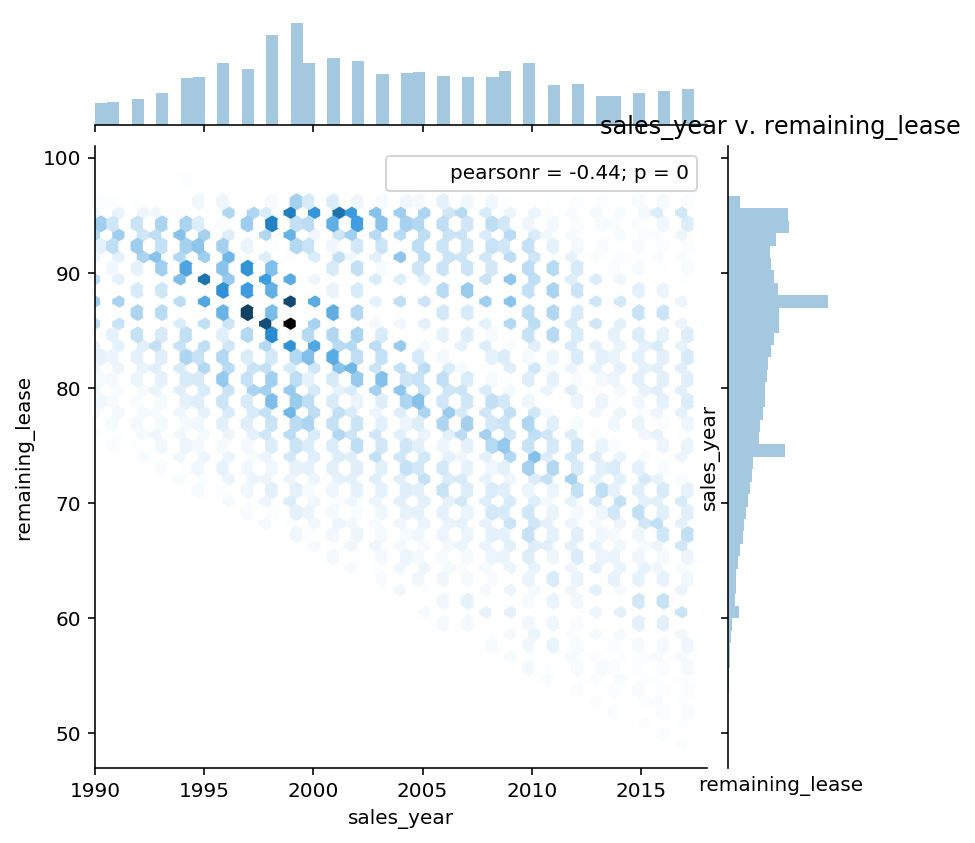

In [77]:
columns = np.array(['resale_price','floor_area_sqm','lease_commence_date','remaining_lease','sales_year'])

if ('sales_year' not in data.columns):
    data.insert(1,'sales_year',(pd.DatetimeIndex(data['month']).year))

if ('remaining_lease' not in data.columns):
    data['remaining_lease'] = 99 - (data.sales_year - data.lease_commence_date)
    
for i in range(0,len(columns)):
    inpt1 = columns[i] 
    x1 = data[inpt1]
    for j in range (i+1,len(columns)):
        inpt2 = columns[j]
        x2 = data[inpt2]
        sns.jointplot(data=data, x=x2, y=x1, kind='hex')
        plt.title('%s v. %s'%(inpt2,inpt1))
        plt.xlabel('%s'%inpt1)
        plt.ylabel('%s'%inpt2)
        if (inpt1 == 'resale_price'):
            plt.ylim(0,800000)
        elif (inpt1 == 'floor_area_sqm'):
            plt.ylim(40,200)
        plt.show()

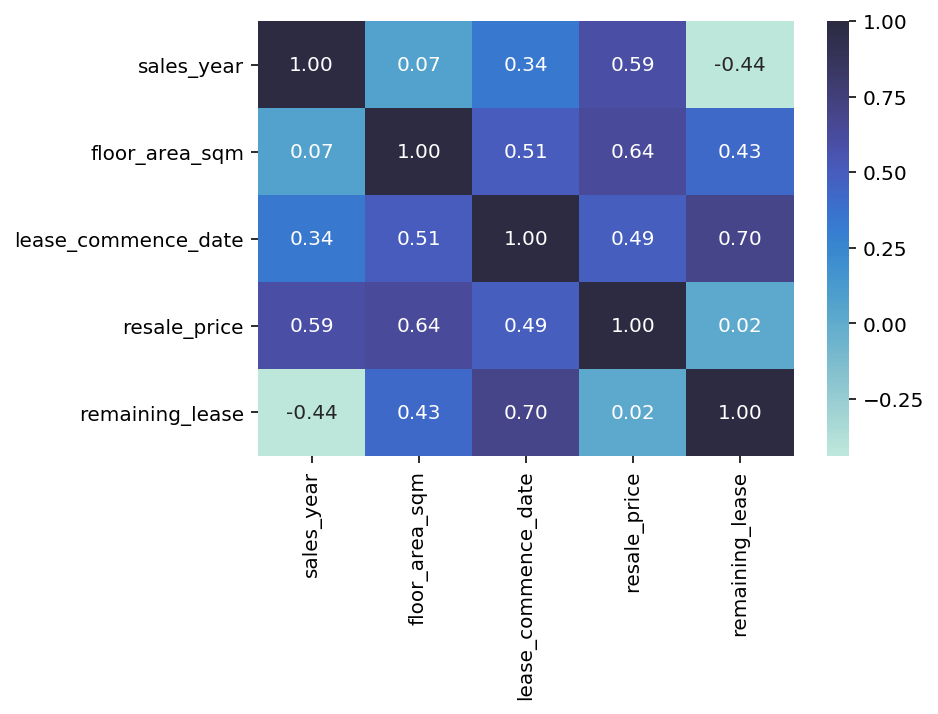

In [78]:
# Correlation heat map
sns.heatmap(data.corr(), annot=True, fmt=".2f",center=1.3)
plt.show()

Observations:
- !!! add text about apartment building policy !!!
- Floor_area has the strongest correlation to the resale_price (Pearson coefficient of 0.64), followed by sales_year (0.59) and then lease_commence_date (0.49).
- Correlations between input features vary between 0.071 and 0.7.

## 2 Exploration of the Dataset
<hr>
To start exploring the data, the dataset are loaded. From the dataset, we can conclude the data contain 768.629 datapoints and 10 features. <br>

https://towardsdatascience.com/5-quick-and-easy-data-visualizations-in-python-with-code-a2284bae952f

### 2.1 Data description

In [9]:
#load dataset
print('Number of training data =', data.shape[0])
print('Number of features =', data.shape[1])

Number of training data = 768629
Number of features = 10


We use data.describe() to have a look at some key metrics of the data set.

In [10]:
print(data.describe())

       floor_area_sqm  lease_commence_date  resale_price
count   768629.000000        768629.000000  7.686290e+05
mean        95.455564          1986.563476  2.823196e+05
std         26.210450             8.851260  1.424499e+05
min         28.000000          1966.000000  5.000000e+03
25%         72.000000          1980.000000  1.750000e+05
50%         93.000000          1985.000000  2.650000e+05
75%        114.000000          1993.000000  3.700000e+05
max        307.000000          2015.000000  1.180000e+06


We can conclude:
- All appartments vary between the size of 28 and 307 sqm. The mean is 95.46 sqm.
- The oldest lease start date is 1966 and the oldest one is 2015. Thus no appartment in this list has a lease that expires before 2065. The mean lease start date is 1987. 
- Resale prices vary between 5000 SGD and 1.18 million SGD. It has to be verified if a price of 5000SGD is possible or is due to faulty data. The median price lies at 282k SGD.
- Overall, at a first glance the dataset seems to be clean and free of faulty datapoints. <br>

In the subsequent section, the data types are retrieved from the dataset.

In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768629 entries, 0 to 58630
Data columns (total 10 columns):
month                  768629 non-null object
town                   768629 non-null object
flat_type              768629 non-null object
block                  768629 non-null object
street_name            768629 non-null object
storey_range           768629 non-null object
floor_area_sqm         768629 non-null float64
flat_model             768629 non-null object
lease_commence_date    768629 non-null int64
resale_price           768629 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 64.5+ MB
None


We can see that the data list is complete, as all features have 768.629 values.

After loading the data, the data are explored. Features are checked to see whether cleaning and preprocessing of the data is needed.

### 2.2 Univariate Plots

#### 2.2.1 Sales Trend

Total Sales Year Count: 29


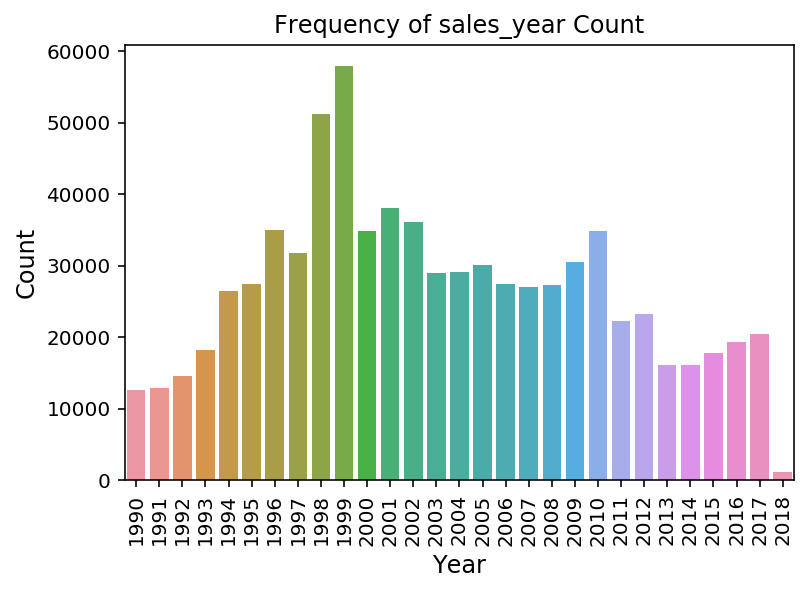

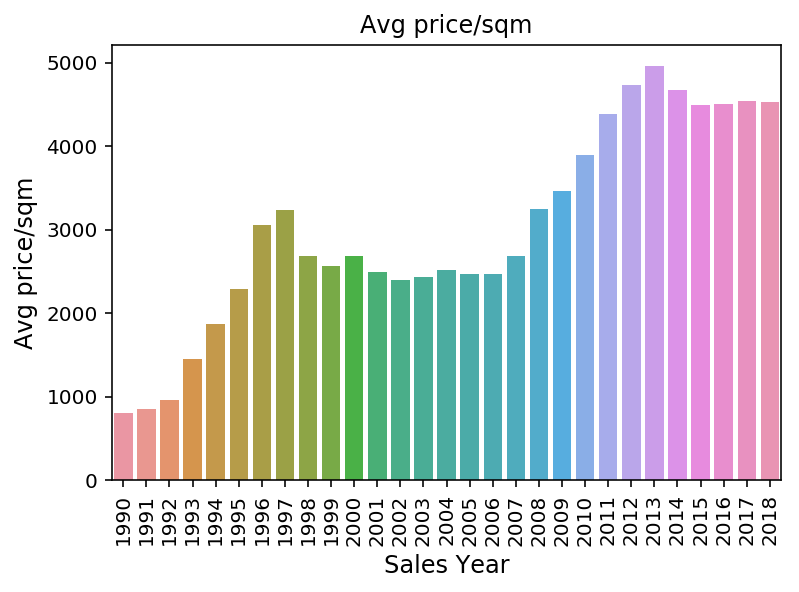

In [12]:
#yearly sales trend
count_sales_year = (pd.DatetimeIndex(data['month']).year).nunique()
print("Total Sales Year Count:", count_sales_year)
#sales_year_count = (pd.DatetimeIndex(data['month']).year).value_counts()
#print("Sales Year Count \n" +str(sales_year_count))

sales_year = np.unique(pd.DatetimeIndex(data['month']).year.values)
year_count=pd.DatetimeIndex(data['month']).year.value_counts()

sns.barplot(year_count.index, year_count.values, order=sales_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()

#sales year vs avg price/sqm
n = len(sales_year)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).year == sales_year[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).year == sales_year[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(sales_year,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Sales Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- Counts of Sales per year increase from 1990 to 1999 and decrease thereafter.
- As expected, in general, prices per sqm increase over time.
- However there was a dip after 1997 and after 2013.

Looking at the observations, we can see that there are basically three different periods. To develop a good prediction model, we can consider that the data points before 2010 are not useful for the future predictions. To test this assumption, we divide the data into three datasets. 

Total Sales Month Count: 12


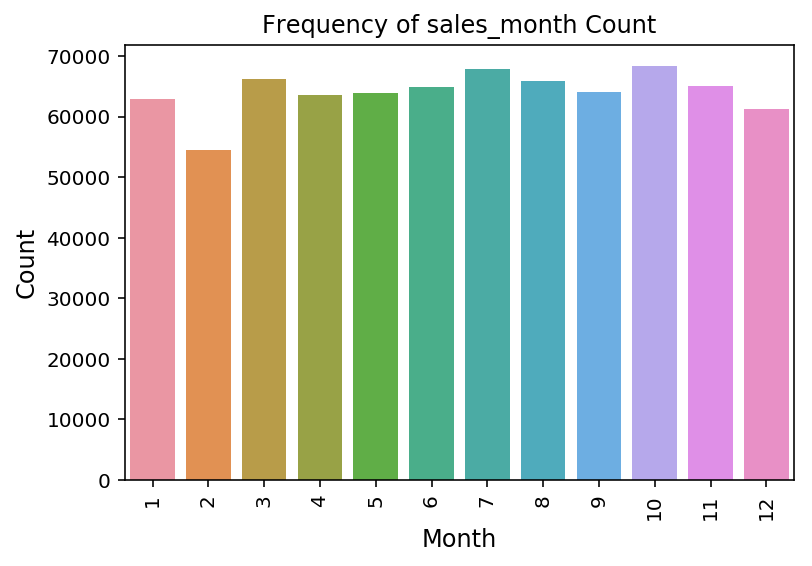

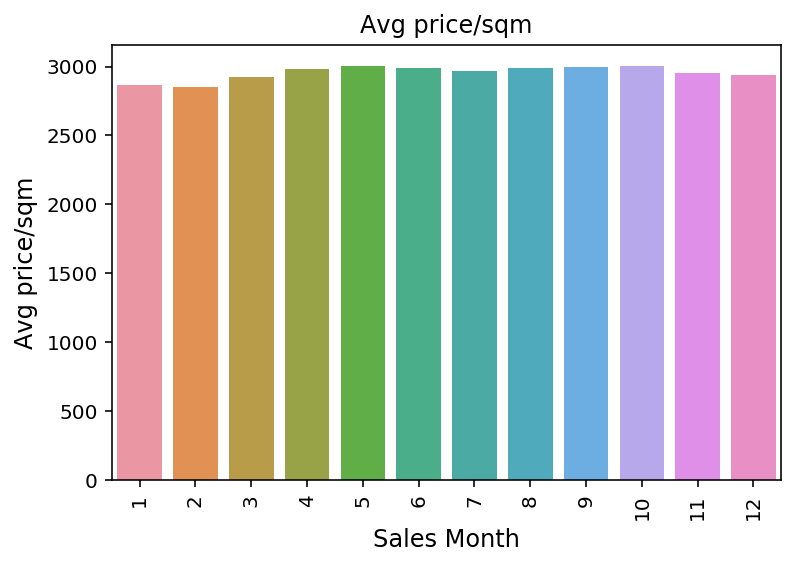

In [40]:
#monthly sales trend
count_sales_month = (pd.DatetimeIndex(data['month']).month).nunique()
print("Total Sales Month Count:", count_sales_month)
#sales_month_count = (pd.DatetimeIndex(data['month']).month).value_counts()
#print("Sales Month Count \n" +str(sales_month_count))

sales_month = np.unique(pd.DatetimeIndex(data['month']).month.values)
month_count=pd.DatetimeIndex(data['month']).month.value_counts()

sns.barplot(month_count.index, month_count.values, order=sales_month)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_month Count", fontsize=12)
plt.show()

#sales month vs avg price/sqm
n = len(sales_month)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).month == sales_month[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).month == sales_month[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(sales_month,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Sales Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- It seems like the last and first month of a year have slightly lower prices than the middle months. <br>

#### 2.2.2 Feature: Lease Commencement Year

Total Lease Commence Count: 50


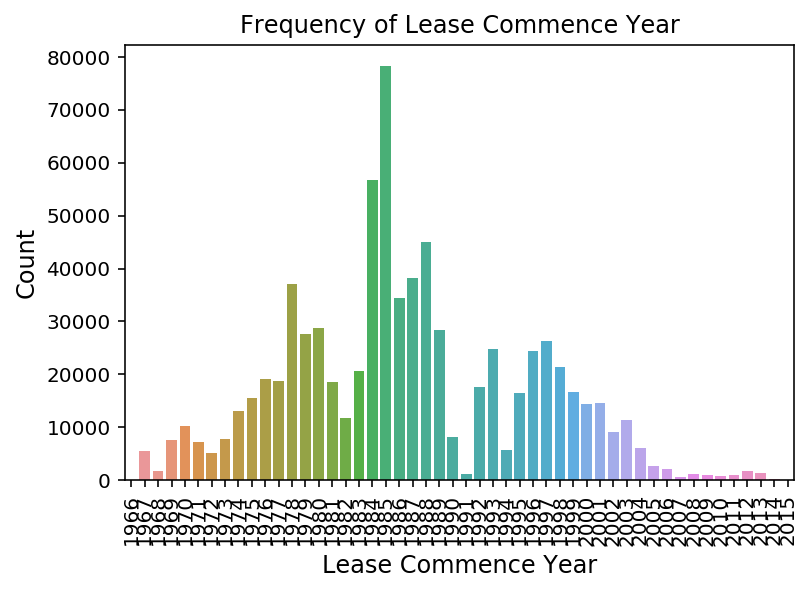

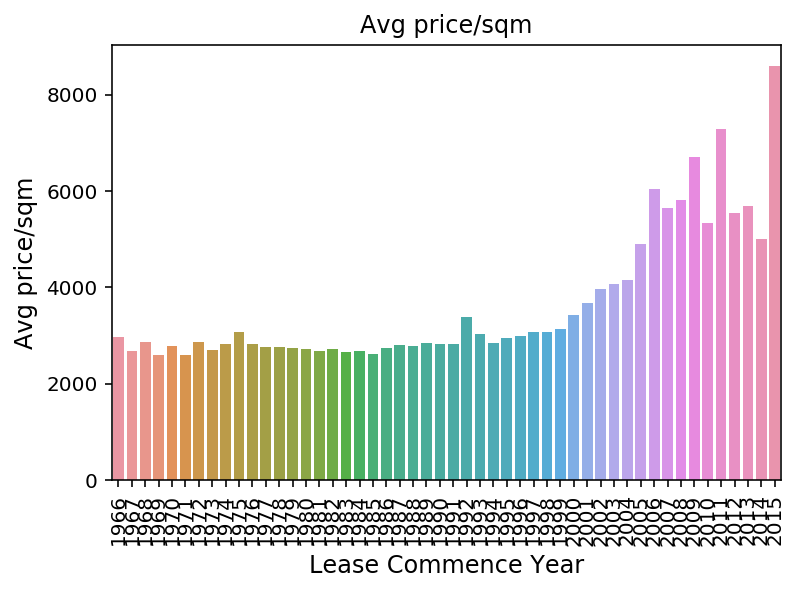

In [34]:
#lease commencement year
count_lease_commence = data['lease_commence_date'].nunique()
print("Total Lease Commence Count:", count_lease_commence)
#lease_commence_count = data['lease_commence_date'].value_counts()
#print("Lease Commence Count \n" +str(lease_commence_count))

lease_commence = np.unique(data['lease_commence_date'])

sns.countplot(x="lease_commence_date", data=data , order = lease_commence)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Lease Commence Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Lease Commence Year", fontsize=12)
plt.show()

#town vs avg price/sqm
n = len(lease_commence)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['lease_commence_date'] == lease_commence[i]].sum()
        sqmm = data['floor_area_sqm'][data['lease_commence_date'] == lease_commence[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(lease_commence,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Lease Commence Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- The years 1984-1990 have the most commencement dates. Before, there is an ongoing increase and after an ongoing decrease.
- Prices/sqm remain relatively flat for commencement dates from 1966 to 2000 and increase from 2000 to 2012. After 2012 the prices decrease heavily and in 2015, it almost doubled again. <br>


#### 2.2.3 Feature: Town

Total Town Count: 27


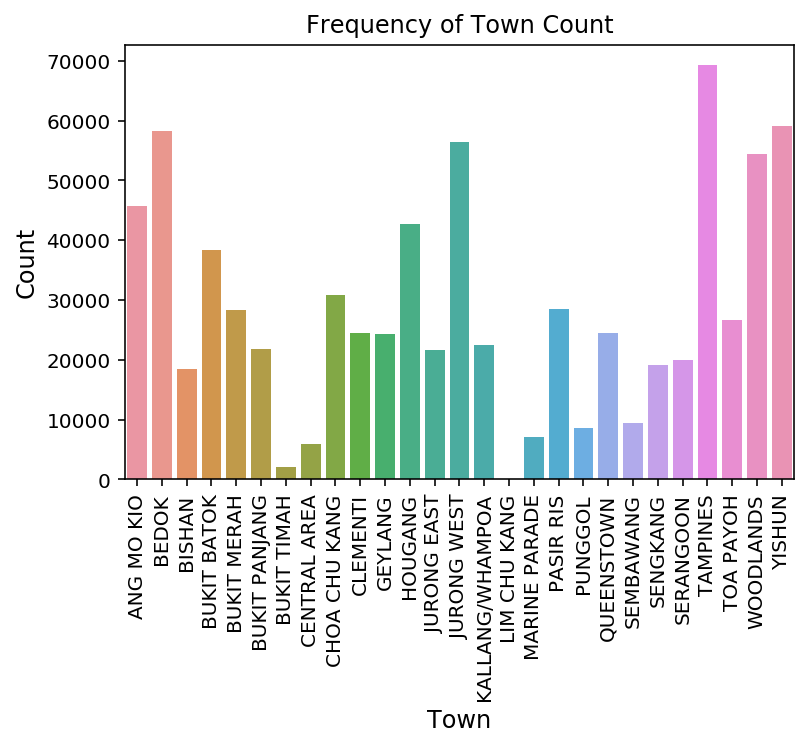

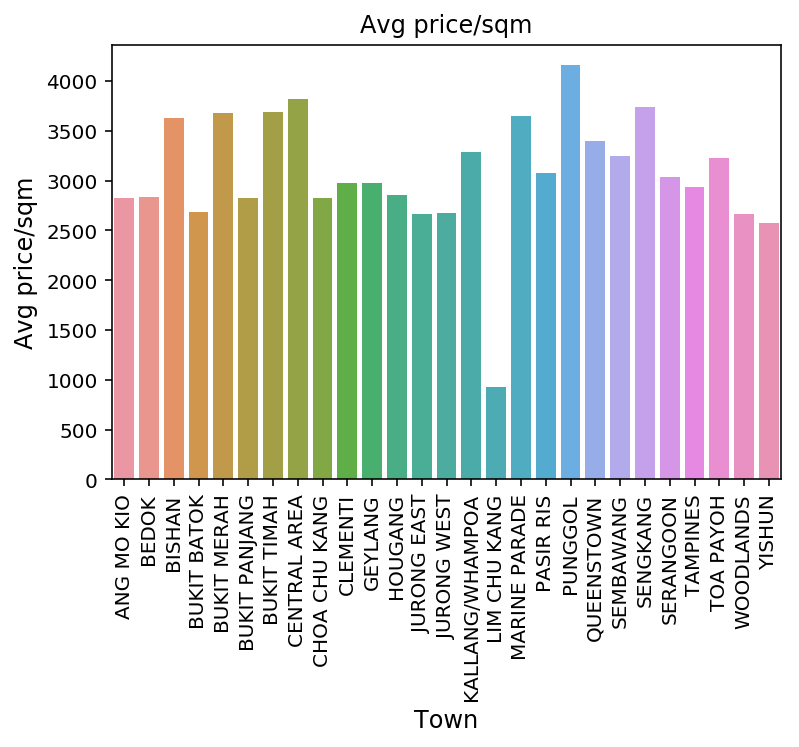

In [6]:
#town count
count_towns = data['town'].nunique()
print("Total Town Count:", count_towns)
#towns_count = data['town'].value_counts()
#print("Town Count \n" +str(towns_count))

town = np.unique(data['town'])

sns.countplot(x="town", data=data , order = town)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Town Count", fontsize=12)
plt.show()

#town vs avg price/sqm
n = len(town)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['town'] == town[i]].sum()
        sqmm = data['floor_area_sqm'][data['town'] == town[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(town,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- Besides Bukit Timah and Lim Chu Kang, all towns have more than 5000 sales occurrences.
- TAMPINES is the most present town, with 69236 sales.
- Lim Chu Kang is a clear outlier in terms of price/sqm. This is probably correlated to the low number of only 64 sales registered in that area.
- The most expensive town is Punggol. 

### Singaporean Townships and Areas
The Housing and Development Board makes a distinction between a total of 23 townships, located in 5 different areas [12]. The areas define their location within the city-state, whereas the township concatenates a community with its own council. The map below highlights the areas and townships. The areas are respectively: north (red), nort-east (yellow), east (blue), central (brown) and west (green). The pins indicate the townships included.

In [9]:
IFrame('https://www.google.com/maps/d/u/0/embed?mid=1Gv4-kVYanSXMj8Q2ldJKJkzTilOlEZxL', width=800, height=300)

#### 2.2.4 Feature: Flat Type

Total Flat Type Count: 8


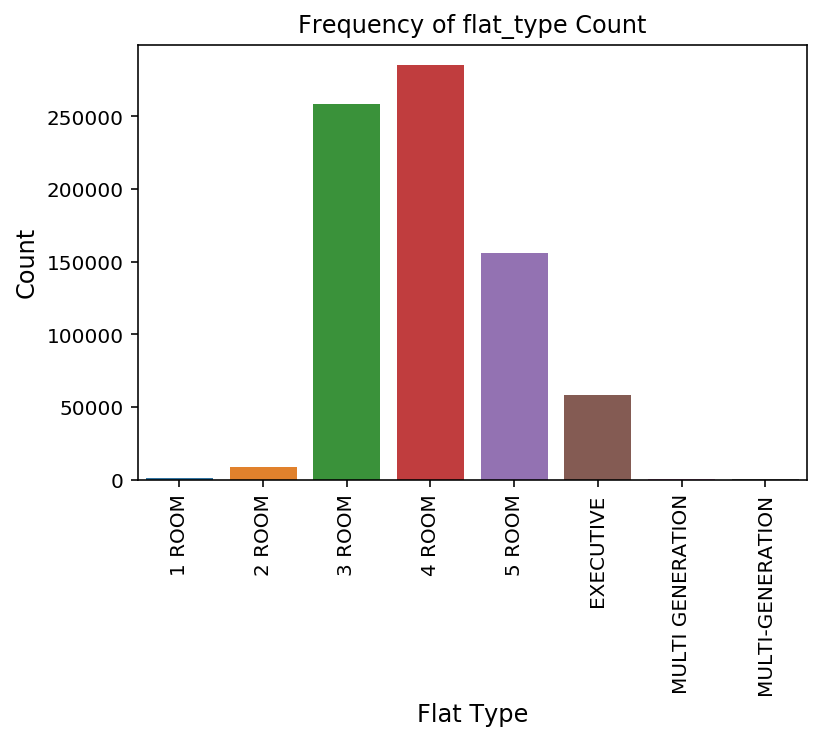

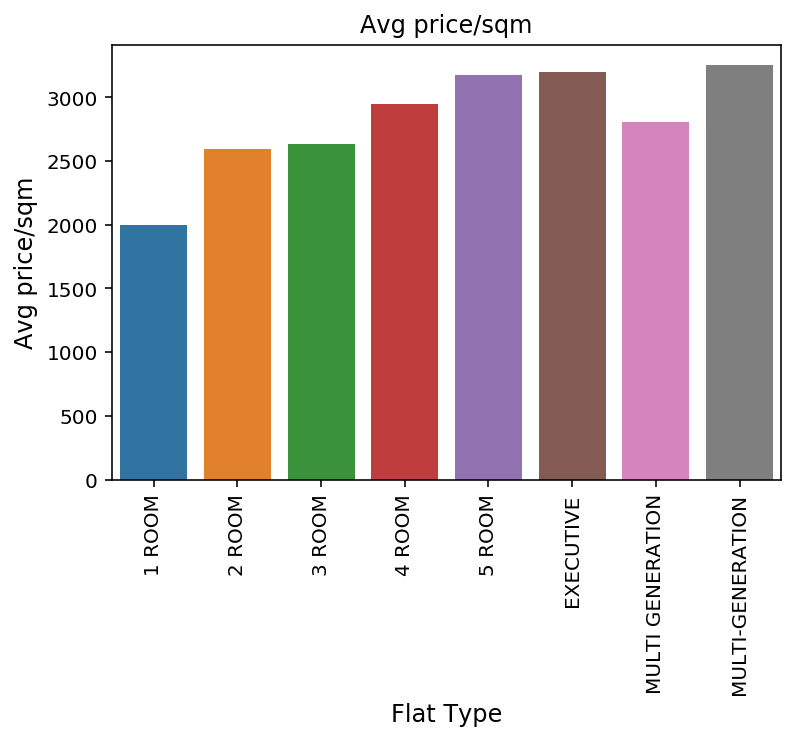

In [24]:
#flat_type count
count_flat_type = data['flat_type'].nunique()
print("Total Flat Type Count:", count_flat_type)
#flat_type_count = data['flat_type'].value_counts()
#print("Flat Type Count \n" +str(flat_type_count))

flat_type = np.unique(data['flat_type'])

sns.countplot(x="flat_type", data=data , order = flat_type)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Flat Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_type Count", fontsize=12)
plt.show()

#flat type vs avg price/sqm
n = len(flat_type)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_type'] == flat_type[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_type'] == flat_type[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(flat_type,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- 1 Room, 2 Room, and Multi-Generations are clearly fewer than the remaining flat types.
- The most common flat type is 4 rooms.
- Prices per sqm, surprisingly, seem to up with flat size. <br>

#### 2.2.5 Feature: Flat Model

Total Flat Model Count: 34


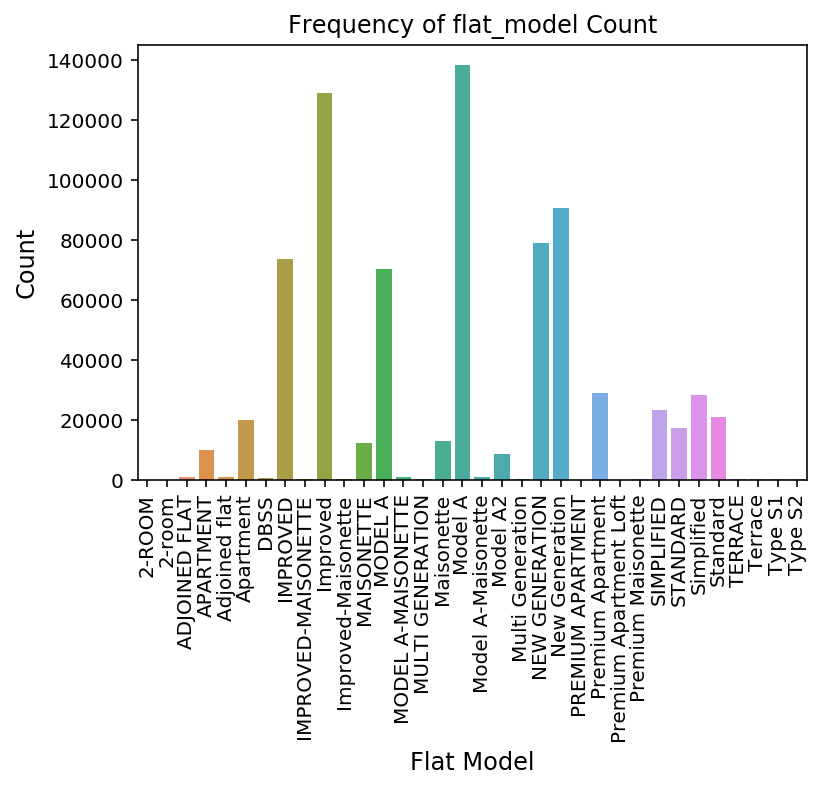

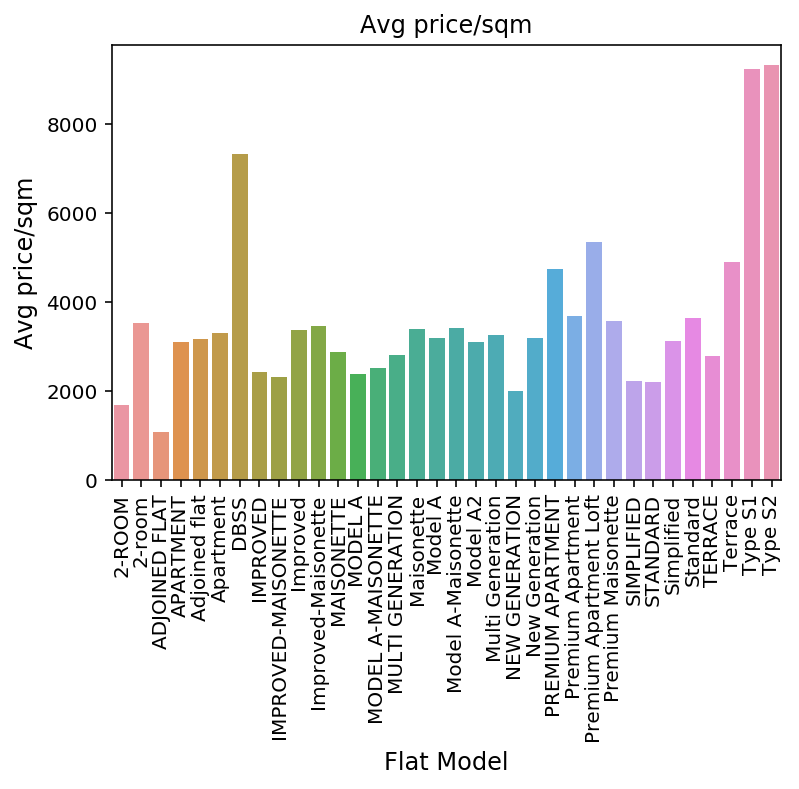

In [30]:
#flat_model count
count_flat_model = data['flat_model'].nunique()
print("Total Flat Model Count:", count_flat_model)
#flat_model_count = data['flat_model'].value_counts()
#print("Flat Model Count \n" +str(flat_model_count))

flat_model = np.unique(data['flat_model'])

sns.countplot(x="flat_model", data=data , order = flat_model)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_model Count", fontsize=12)
plt.show()

#flat model vs avg price/sqm
n = len(flat_model)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_model'] == flat_model[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_model'] == flat_model[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(flat_model,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Obersvations:
- Concerning flat_models, there are lot of flat_models that exist less than a 1000 times.
- The most common ones are 'Model A' and 'Improved'.
- Prices/sqm vary widely, which is probably due to some sample sizes being very small. <br>

#### 2.2.6 Feature: Storey Range

Total Storey Range Count: 25
Storey Range Count 
04 TO 06    196169
07 TO 09    177012
01 TO 03    158446
10 TO 12    149470
13 TO 15     46780
16 TO 18     16906
19 TO 21      8337
22 TO 24      5233
01 TO 05      2700
06 TO 10      2474
25 TO 27      2100
11 TO 15      1259
28 TO 30       788
16 TO 20       265
31 TO 33       151
34 TO 36       151
37 TO 39       148
21 TO 25        92
40 TO 42        73
26 TO 30        39
43 TO 45        11
46 TO 48        11
36 TO 40         7
49 TO 51         5
31 TO 35         2
Name: storey_range, dtype: int64


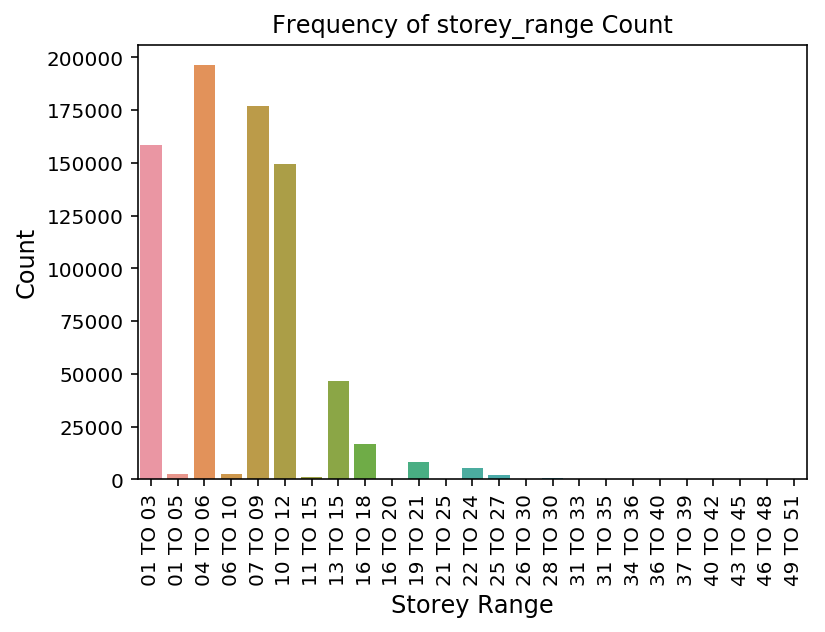

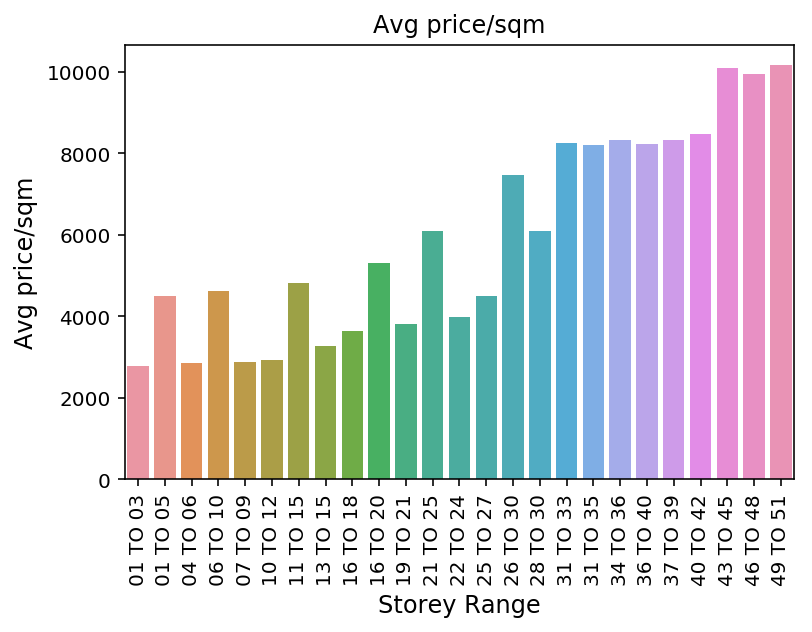

In [91]:
#storey range count
count_storey_range = data['storey_range'].nunique()
print("Total Storey Range Count:", count_storey_range)
storey_range_count = data['storey_range'].value_counts()
print("Storey Range Count \n" +str(storey_range_count))

storey_array = np.unique(data['storey_range'])

sns.countplot(x="storey_range", data=data , order = storey_array)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Storey Range', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of storey_range Count", fontsize=12)
plt.show()

#storey range vs avg price/sqm
n = len(storey_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['storey_range'] == storey_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['storey_range'] == storey_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(storey_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Storey Range', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- There is a clear upwards trend in prices for higher stories.
- There are few storey ranges that spike in price.
- Those ranges also tend to have really low frequency.
- These ranges also tend to be included in other ranges.
- It is possible that e.g. in recent years, which have higher prices, the storey format changed; which would explain higher avg. prices per sqm. <br>

Since the storey range is ranging differently at a certain point. We are checking in which dataset(s) this is happening. Following the data below, we can see that dataset 4 behaves unusual.

In [75]:
print(np.unique(data1['storey_range']))
print(np.unique(data2['storey_range']))
print(np.unique(data3['storey_range']))
print(np.unique(data4['storey_range']))
print(np.unique(data5['storey_range']))

['01 TO 03' '04 TO 06' '07 TO 09' '10 TO 12' '13 TO 15' '16 TO 18'
 '19 TO 21' '22 TO 24' '25 TO 27']
['01 TO 03' '04 TO 06' '07 TO 09' '10 TO 12' '13 TO 15' '16 TO 18'
 '19 TO 21' '22 TO 24' '25 TO 27' '28 TO 30']
['01 TO 03' '04 TO 06' '07 TO 09' '10 TO 12' '13 TO 15' '16 TO 18'
 '19 TO 21' '22 TO 24' '25 TO 27' '28 TO 30' '31 TO 33' '34 TO 36'
 '37 TO 39' '40 TO 42']
['01 TO 03' '01 TO 05' '04 TO 06' '06 TO 10' '07 TO 09' '10 TO 12'
 '11 TO 15' '13 TO 15' '16 TO 18' '16 TO 20' '19 TO 21' '21 TO 25'
 '22 TO 24' '25 TO 27' '26 TO 30' '28 TO 30' '31 TO 33' '31 TO 35'
 '34 TO 36' '36 TO 40' '37 TO 39' '40 TO 42']
['01 TO 03' '04 TO 06' '07 TO 09' '10 TO 12' '13 TO 15' '16 TO 18'
 '19 TO 21' '22 TO 24' '25 TO 27' '28 TO 30' '31 TO 33' '34 TO 36'
 '37 TO 39' '40 TO 42' '43 TO 45' '46 TO 48' '49 TO 51']


#### 2.2.7 Feature: Squared Meters Distribution

Total SQM Range Count: 209


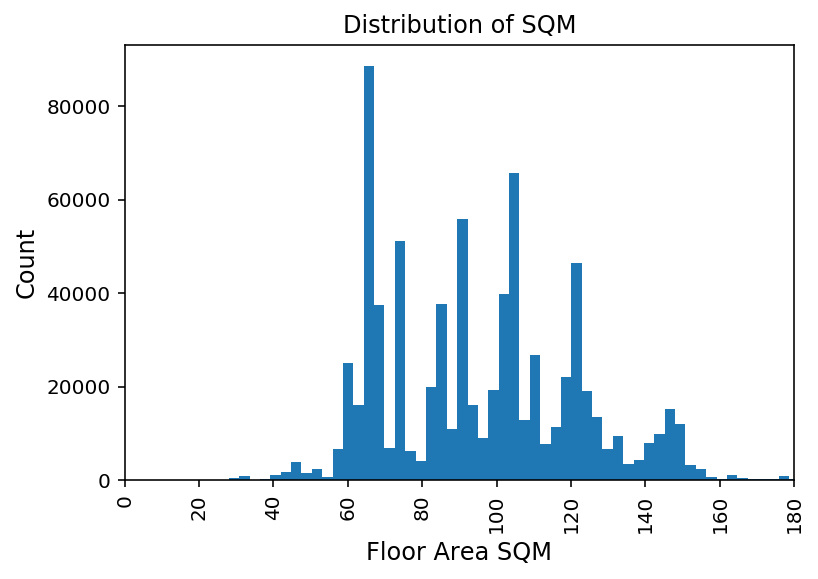

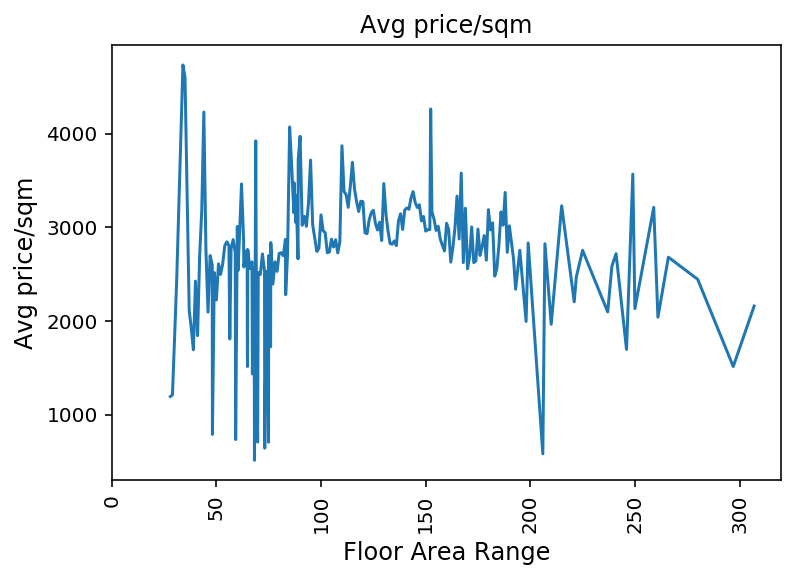

In [47]:
#SQM distribution
count_sqm = data['floor_area_sqm'].nunique()
print("Total SQM Range Count:", count_sqm)
#sqm_count = data['floor_area_sqm'].value_counts()
#print("SQM Range Count \n" +str(sqm_count))

sqm_area = np.unique(data['floor_area_sqm'])

plt.hist(data['floor_area_sqm'], bins = 100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Floor Area SQM', fontsize=12)
plt.xlim(0,180)
plt.xticks(rotation='vertical')
plt.title("Distribution of SQM", fontsize=12)
plt.show()

#storey range vs avg price/sqm
n = len(sqm_area)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['floor_area_sqm'] == sqm_area[i]].sum()
        sqmm = data['floor_area_sqm'][data['floor_area_sqm'] == sqm_area[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
plt.plot(sqm_area,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Floor Area Range', fontsize=12)
plt.xlim(0,320)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:
- We can see that the largest chunk of the HBDs are between 25 and 200 sqm.
- There are strong variations of counts between the different bins.
- Prices per sqm seem to be highest in the mid-range of SQM. <br>

#### 2.2.8 Feature: Resale Price

Total Resale Price Range Count: 8082


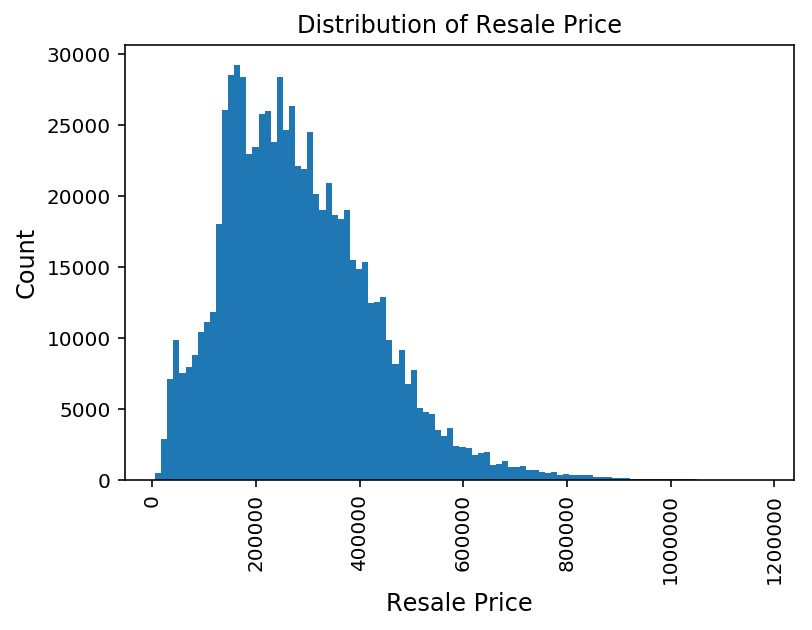

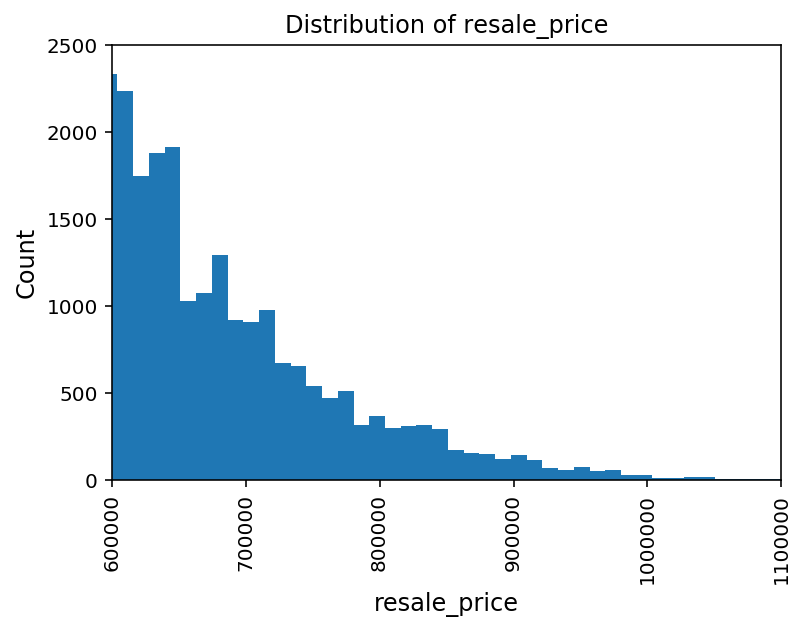

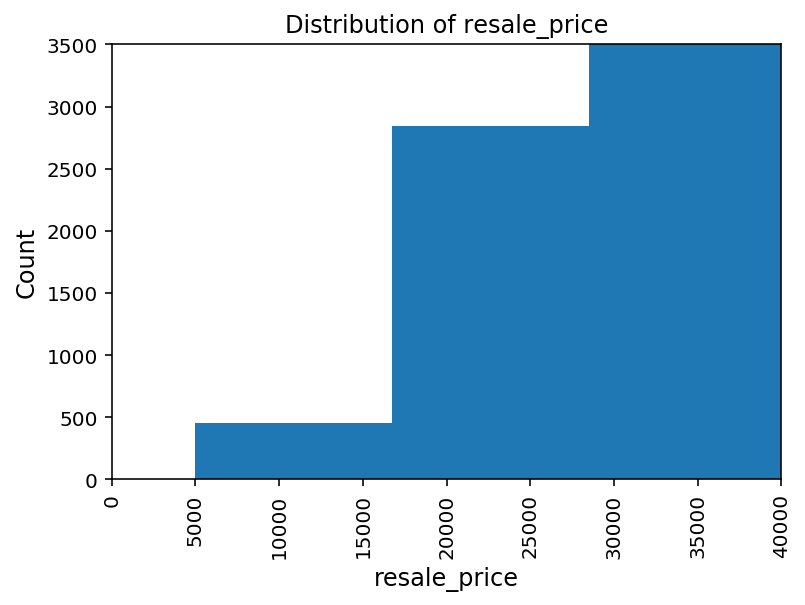

In [65]:
#resale price distribution
count_price = data['resale_price'].nunique()
print("Total Resale Price Range Count:", count_price)
#price_count = data['resale_price'].value_counts()
#print("Resale Price Range Count \n" +str(price_count))

plt.hist(data['resale_price'], bins = 100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Resale Price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of Resale Price", fontsize=12)
plt.show()

#resale prices above $1,000,000
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,2500)
plt.xlim(600000,1100000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

#resale prices under $10,000
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,3500)
plt.xlim(0,40000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

Observations:
- Practically no prices per flat go above 1,000,000 SGD.
- The majority of prices are between 150,000 and 400,000 SGD.
- There seems to be a number of flats (400+) that were sold for less than 10,000 SGD. <br>